# Multi-Momentum PID Analysis: XGBoost + Deep Neural Network Ensemble
## Particle Identification with Optuna, Model Caching & Ensemble Methods

This notebook implements an **ensemble approach** combining:
- **XGBoost**: Traditional gradient boosting for feature importance and sharp boundaries
- **Deep Neural Networks (DNN)**: Deep learning for complex feature interactions
- **Ensemble Voting**: Combines both models for optimal performance


In [ ]:
!pip install hipe4ml optuna pandas numpy matplotlib seaborn scikit-learn xgboost ipywidgets tensorflow keras -q
!pip install scikit-learn>=1.6 -q
!pip install pytorch-tabnet -q
print("✓ Dependencies installed")

✓ Dependencies installed


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pickle
import os
import json

from hipe4ml.model_handler import ModelHandler
from hipe4ml import plot_utils

import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
import ipywidgets as widgets
from IPython.display import display, clear_output

from pytorch_tabnet.tab_model import TabNetClassifier

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## SECTION 1: Configuration
### Define Momentum Ranges, Particles & Storage Paths

In [ ]:
print("="*80)
print("SECTION 1: CONFIGURATION")
print("="*80)

drive.mount('/content/drive')

MOMENTUM_RANGES = {
    'full': {'name': 'All Data (full spectrum)', 'min': 0.0,  'max': 999, 'color': '#9333EA'},
    'low':  {'name': '0.1-1 GeV/c',           'min': 0.1, 'max': 1.0,  'color': '#3B82F6'},
    'mid':  {'name': '1-3 GeV/c',            'min': 1.0, 'max': 3.0,  'color': '#F59E0B'},
    'high': {'name': '3+ GeV/c',             'min': 3.0, 'max': 999,  'color': '#22C55E'}
}

PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']

# Storage directories
BASE_DIR = '/content/drive/MyDrive/PID_Models/'
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'XGBoost/')
DNN_SAVE_DIR = os.path.join(BASE_DIR, 'DNN/')
OPTUNA_SAVE_DIR = os.path.join(BASE_DIR, 'Optuna_Studies/')
ENSEMBLE_SAVE_DIR = os.path.join(BASE_DIR, 'Ensemble/')

for directory in [MODEL_SAVE_DIR, DNN_SAVE_DIR, OPTUNA_SAVE_DIR, ENSEMBLE_SAVE_DIR]:
    os.makedirs(directory, exist_ok=True)

print("✓ Configuration loaded")
print(f"  Momentum ranges: {list(MOMENTUM_RANGES.keys())}")
print(f"  Base storage: {BASE_DIR}")

SECTION 1: CONFIGURATION
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Configuration loaded
  Momentum ranges: ['full', 'low', 'mid', 'high']
  Base storage: /content/drive/MyDrive/PID_Models/


### Save/Load Functions for XGBoost, DNN & Optuna Studies

In [ ]:
# XGBOOST SAVE/LOAD
def save_xgboost_model(range_key, model_info, dataset_info):
    save_path = os.path.join(MODEL_SAVE_DIR, f'xgb_model_{range_key}.pkl')
    save_data = {
        'model': model_info['model_handler'].model,
        'features': available_features,
        'config': model_info['config'],
        'train_acc': model_info['train_acc'],
        'test_acc': model_info['test_acc'],
        'train_auc': model_info.get('train_auc', 0),
        'test_auc': model_info.get('test_auc', 0),
        'n_train': dataset_info['n_train'],
        'n_test': dataset_info['n_test']
    }
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"   Saved XGBoost model: {save_path}")

def load_xgboost_model(range_key):
    load_path = os.path.join(MODEL_SAVE_DIR, f'xgb_model_{range_key}.pkl')
    if not os.path.exists(load_path):
        return None
    with open(load_path, 'rb') as f:
        save_data = pickle.load(f)
    model_hdl = ModelHandler(save_data['model'], save_data['features'])
    model_hdl.model = save_data['model']
    return {
        'model_handler': model_hdl,
        'config': save_data['config'],
        'train_acc': save_data['train_acc'],
        'test_acc': save_data['test_acc'],
        'train_auc': save_data.get('train_auc', 0),
        'test_auc': save_data.get('test_auc', 0)
    }

# DNN SAVE/LOAD
def save_dnn_model(range_key, dnn_model, scaler, metrics_dict):
    model_path = os.path.join(DNN_SAVE_DIR, f'dnn_model_{range_key}.keras')
    dnn_model.save(model_path)

    # Save scaler and metrics
    scaler_path = os.path.join(DNN_SAVE_DIR, f'dnn_scaler_{range_key}.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    metrics_path = os.path.join(DNN_SAVE_DIR, f'dnn_metrics_{range_key}.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics_dict, f)

    print(f"   Saved DNN model: {model_path}")

def load_dnn_model(range_key):
    model_path = os.path.join(DNN_SAVE_DIR, f'dnn_model_{range_key}.keras')
    if not os.path.exists(model_path):
        return None

    dnn_model = keras.models.load_model(model_path)

    scaler_path = os.path.join(DNN_SAVE_DIR, f'dnn_scaler_{range_key}.pkl')
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    metrics_path = os.path.join(DNN_SAVE_DIR, f'dnn_metrics_{range_key}.json')
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)

    return {'model': dnn_model, 'scaler': scaler, 'metrics': metrics}

# OPTUNA SAVE/LOAD
def save_optuna_study(range_key, study):
    save_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_{range_key}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"   Saved Optuna study: {save_path}")

def load_optuna_study(range_key):
    load_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_{range_key}.pkl')
    if not os.path.exists(load_path):
        return None
    with open(load_path, 'rb') as f:
        study = pickle.load(f)
    return study

def check_saved_models():
    xgb_models = [
        f.replace('xgb_model_', '').replace('.pkl', '')
        for f in os.listdir(MODEL_SAVE_DIR)
        if f.startswith('xgb_model_') and f.endswith(".pkl")
    ]
    dnn_models = [
        f.replace('dnn_model_', '').replace('.keras', '')
        for f in os.listdir(DNN_SAVE_DIR)
        if f.startswith('dnn_model_') and f.endswith('.keras')
    ]
    return {'xgb': xgb_models, 'dnn': dnn_models}

print("✓ Save/Load functions defined")

✓ Save/Load functions defined


## SECTION 2: Data Loading & Cleaning
### Load CSV & Prepare Features

In [ ]:
print("\n" + "="*80)
print("SECTION 2: DATA LOADING & CLEANING")
print("="*80)

csv_file_path = '/content/drive/MyDrive/pid_features_large.csv'
df_iter = pd.read_csv(csv_file_path, dtype='float32', chunksize=500_000, low_memory=False)
df = pd.concat(df_iter, ignore_index=True)
print(f"✓ Loaded: {df.shape}")

# Clean data
df.replace(-999, np.nan, inplace=True)

# Define feature groups
tof_features = [col for col in df.columns if 'tof' in col.lower()]
tpc_features = [col for col in df.columns if 'tpc' in col.lower()]
bayes_features = [col for col in df.columns if 'bayes_prob' in col.lower()]

# Fill missing values for each feature group
df[tof_features] = df[tof_features].fillna(0)
df[tpc_features] = df[tpc_features].fillna(0)

# Handle missing Bayesian data
df[bayes_features] = df[bayes_features].fillna(0)

# Create indicator features
df['has_tof'] = (df[tof_features].abs().sum(axis=1) > 0).astype(int)
df['has_tpc'] = (df[tpc_features].abs().sum(axis=1) > 0).astype(int)

# Drop rows missing critical features
df.dropna(subset=['pt', 'eta', 'mc_pdg'], inplace=True)
print(f"✓ Cleaned: {df.shape}")

# PDG mapping
def pdg_to_species(pdg):
    ap = abs(int(pdg))
    if ap == 211:          return 0
    elif ap == 321:        return 1
    elif ap == 2212:       return 2
    elif ap == 11:         return 3
    else: return -1

df['particle_species'] = df['mc_pdg'].apply(pdg_to_species)
df = df[df['particle_species'] >= 0].reset_index(drop=True)

# Feature engineering
for feature in ['pt', 'p', 'tpc_signal', 'tof_beta']:
    if feature in df.columns:
        df[feature] = np.log1p(df[feature].abs())

# Define all training features
training_features = [
    'pt', 'eta', 'phi',
    'tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
    'tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
    'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
    'dca_xy', 'dca_z', 'has_tpc', 'has_tof'
]
available_features = [f for f in training_features if f in df.columns]
print(f"✓ Features: {len(available_features)}")

# Verify no missing values in final dataset
missing_count = df[available_features].isnull().sum().sum()
if missing_count > 0:
    print(f"⚠ Warning: {missing_count} missing values found in features, dropping rows with NaNs")
    df = df.dropna(subset=available_features)
else:
    print(f"✓ No missing values in training features")

print(f"✓ Final dataset: {df.shape}")
print(f"✓ Available features: {available_features}")


SECTION 2: DATA LOADING & CLEANING
✓ Loaded: (4729393, 37)
✓ Cleaned: (4729392, 37)
✓ Features: 21
✓ No missing values in training features
✓ Final dataset: (4163954, 38)
✓ Available features: ['pt', 'eta', 'phi', 'tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el', 'tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el', 'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el', 'dca_xy', 'dca_z', 'has_tpc', 'has_tof']


## SECTION 3: Momentum Range Splitting
### Prepare 4 Independent Datasets

In [ ]:
print("\n" + "="*80)
print("SECTION 3: MOMENTUM RANGE SPLITTING")
print("="*80)

momentum_datasets = {}

for range_key, range_config in MOMENTUM_RANGES.items():
    print(f"\n{range_config['name']}")
    df_range = df[(df['pt'] >= range_config['min']) & (df['pt'] < range_config['max'])].copy()
    print(f"   Tracks: {len(df_range):,}")

    if len(df_range) == 0 or df_range['particle_species'].value_counts().min() < 10:
        continue

    X = df_range[available_features].astype('float32')
    y = df_range['particle_species']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=available_features).astype('float32')

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
    X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
    y_train, y_test = pd.Series(y_train.values), pd.Series(y_test.values)

    momentum_datasets[range_key] = {
        'config': range_config,
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'scaler': scaler,
        'n_train': len(X_train), 'n_test': len(X_test)
    }
    print(f"   Train: {len(X_train):,}, Test: {len(X_test):,}")

print(f"\n✓ Prepared {len(momentum_datasets)} ranges")


SECTION 3: MOMENTUM RANGE SPLITTING

All Data (full spectrum)
   Tracks: 4,163,954
   Train: 2,914,767, Test: 1,249,187

0.1-1 GeV/c
   Tracks: 3,956,919
   Train: 2,769,843, Test: 1,187,076

1-3 GeV/c
   Tracks: 128,035
   Train: 89,624, Test: 38,411

3+ GeV/c
   Tracks: 157
   Train: 109, Test: 48

✓ Prepared 4 ranges


## SECTION 4: Optuna Hyperparameter Optimisation
### Optimise XGBoost Parameters (with Auto-Load & Save)

In [ ]:
print("\n" + "="*80)
print("SECTION 4: OPTUNA OPTIMISATION FOR XGBOOST")
print("="*80)

optuna_studies_xgb = {}
FORCE_REOPTIMIZE_XGB = False

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing XGBoost Optuna: {config['name']}")

    # Try to load
    study_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_xgb_{range_key}.pkl')
    if os.path.exists(study_path) and not FORCE_REOPTIMIZE_XGB:
        print(f"Loading saved XGBoost study...")
        with open(study_path, 'rb') as f:
            study = pickle.load(f)
        optuna_studies_xgb[range_key] = study
        print(f"   Best ROC-AUC: {study.best_value:.4f}")
        continue

    # Optimise
    print(f"Running XGBoost optimisation...")
    X_train_optuna = dataset['X_train'].sample(min(300_000, len(dataset['X_train'])), random_state=42)
    y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 1.0)
        }
        model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1, tree_method='hist')
        model.fit(X_train_optuna, y_train_optuna)
        y_pred = model.predict_proba(dataset['X_test'])
        return roc_auc_score(dataset['y_test'], y_pred, multi_class='ovo', average='weighted')

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=20, show_progress_bar=True)
    optuna_studies_xgb[range_key] = study

    # Save with xgb_ prefix
    save_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_xgb_{range_key}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"   Saved study to: {save_path}")
    print(f"   Best ROC-AUC: {study.best_value:.4f}")

print("\nOptuna XGBoost optimisation complete")



SECTION 4: OPTUNA OPTIMISATION FOR XGBOOST

Processing XGBoost Optuna: All Data (full spectrum)
Loading saved XGBoost study...
   Best ROC-AUC: 0.9384

Processing XGBoost Optuna: 0.1-1 GeV/c
Loading saved XGBoost study...
   Best ROC-AUC: 0.9410

Processing XGBoost Optuna: 1-3 GeV/c
Loading saved XGBoost study...
   Best ROC-AUC: 0.8430

Processing XGBoost Optuna: 3+ GeV/c
Loading saved XGBoost study...
   Best ROC-AUC: 0.6954

Optuna XGBoost optimisation complete


## SECTION 4B: Optuna Hyperparameter Optimisation for DNN
### Optimise Neural Network Architecture & Hyperparameters (with Auto-Load & Save)

In [ ]:
print("\n" + "="*80)
print("SECTION 4B: OPTUNA OPTIMISATION FOR DNN")
print("="*80)

optuna_studies_dnn = {}
FORCE_REOPTIMIZE_DNN = False

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing DNN Optuna: {config['name']}")

    # Try to load
    study_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_dnn_{range_key}.pkl')
    if os.path.exists(study_path) and not FORCE_REOPTIMIZE_DNN:
        print(f"Loading saved DNN study...")
        with open(study_path, 'rb') as f:
            study = pickle.load(f)
        optuna_studies_dnn[range_key] = study
        print(f"   Best validation accuracy: {study.best_value:.4f}")
        continue

    # Optimise
    print(f"Running DNN optimisation...")

    # Sample subset for faster optimisation
    X_train_optuna = dataset['X_train'].sample(min(200_000, len(dataset['X_train'])), random_state=42)
    y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

    # Validation split for Optuna
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_optuna, y_train_optuna, test_size=0.2, random_state=42, stratify=y_train_optuna
    )

    def objective_dnn(trial):
        # Suggest hyperparameters
        n_layers = trial.suggest_int('n_layers', 2, 4)
        units_layer_1 = trial.suggest_categorical('units_layer_1', [128, 256, 512])
        units_layer_2 = trial.suggest_categorical('units_layer_2', [64, 128, 256])
        units_layer_3 = trial.suggest_categorical('units_layer_3', [32, 64, 128])
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
        l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)

        # Build model
        model = keras.Sequential()
        model.add(layers.Input(shape=(len(available_features),)))

        # First layer
        model.add(layers.Dense(units_layer_1, activation='relu',
                              kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

        # Second layer
        model.add(layers.Dense(units_layer_2, activation='relu',
                              kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

        # Optional third and fourth layers
        if n_layers >= 3:
            model.add(layers.Dense(units_layer_3, activation='relu',
                                  kernel_regularizer=regularizers.l2(l2_reg)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(dropout_rate * 0.7))

        if n_layers >= 4:
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dropout(dropout_rate * 0.5))

        # Output layer
        model.add(layers.Dense(len(PARTICLE_NAMES), activation='softmax'))

        # Compile
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train with early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_tr.values, y_tr.values,
            validation_data=(X_val.values, y_val.values),
            batch_size=batch_size,
            epochs=30,
            callbacks=[early_stop],
            verbose=0
        )

        # Return best validation accuracy
        val_acc = max(history.history['val_accuracy'])
        return val_acc

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective_dnn, n_trials=20, show_progress_bar=True)
    optuna_studies_dnn[range_key] = study

    # Save study
    with open(study_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"   Saved study to: {study_path}")
    print(f"   Best validation accuracy: {study.best_value:.4f}")
    print(f"   Best parameters: {study.best_params}")

print("\nOptuna DNN optimisation complete")


SECTION 4B: OPTUNA OPTIMISATION FOR DNN

Processing DNN Optuna: All Data (full spectrum)
Loading saved DNN study...
   Best validation accuracy: 0.8544

Processing DNN Optuna: 0.1-1 GeV/c
Loading saved DNN study...
   Best validation accuracy: 0.8632

Processing DNN Optuna: 1-3 GeV/c
Loading saved DNN study...
   Best validation accuracy: 0.7336

Processing DNN Optuna: 3+ GeV/c
Loading saved DNN study...
   Best validation accuracy: 0.7273

Optuna DNN optimisation complete


## SECTION 4C: Optuna Hyperparameter Optimisation for TabNet
### Optimise TabNet Architecture & Hyperparameters (with Auto-Load & Save)

In [ ]:
print("\n" + "="*80)
print("SECTION 4C: OPTUNA OPTIMISATION FOR TABNET")
print("="*80)

optuna_studies_tabnet = {}
FORCE_REOPTIMIZE_TABNET = False

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing TabNet Optuna: {config['name']}")

    # Try to load
    study_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_tabnet_{range_key}.pkl')
    if os.path.exists(study_path) and not FORCE_REOPTIMIZE_TABNET:
        print(f"Loading saved TabNet study...")
        with open(study_path, 'rb') as f:
            study = pickle.load(f)
        optuna_studies_tabnet[range_key] = study
        print(f"   Best validation accuracy: {study.best_value:.4f}")
        continue

    # Optimise
    print(f"Running TabNet optimisation...")

    # Sample subset for faster optimisation
    X_train_optuna = dataset['X_train'].sample(min(200_000, len(dataset['X_train'])), random_state=42)
    y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

    # Validation split for Optuna
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_optuna, y_train_optuna, test_size=0.2, random_state=42, stratify=y_train_optuna
    )

    def objective_tabnet(trial):
        # Suggest hyperparameters for TabNet
        n_d = trial.suggest_int('n_d', 8, 64)
        n_a = trial.suggest_int('n_a', 8, 64)
        n_steps = trial.suggest_int('n_steps', 3, 10)
        gamma = trial.suggest_float('gamma', 1.0, 2.0)
        lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])

        try:
            model = TabNetClassifier(
                n_d=n_d,
                n_a=n_a,
                n_steps=n_steps,
                gamma=gamma,
                lambda_sparse=lambda_sparse,
                mask_type='sparsemax',
                seed=42
            )

            # Train model - NO verbose parameter
            model.fit(
                X_train=X_tr.values.astype(np.float32),
                y_train=y_tr.values.astype(np.int64),
                eval_set=[(X_val.values.astype(np.float32), y_val.values.astype(np.int64))],
                max_epochs=40,
                patience=5,
                batch_size=batch_size
            )

            # Evaluate on validation set
            y_pred = model.predict_proba(X_val.values.astype(np.float32))
            val_acc = np.mean(np.argmax(y_pred, axis=1) == y_val.values)
            return val_acc

        except Exception as e:
            print(f"   Trial failed: {str(e)[:80]}")
            return 0.0

    # Create and run study
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective_tabnet, n_trials=20, show_progress_bar=True)
    optuna_studies_tabnet[range_key] = study

    # Save study
    with open(study_path, 'wb') as f:
        pickle.dump(study, f)

    print(f"   Saved study to: {study_path}")
    print(f"   Best validation accuracy: {study.best_value:.4f}")
    print(f"   Best parameters: {study.best_params}")

print("\nOptuna TabNet optimisation complete")


SECTION 4C: OPTUNA OPTIMISATION FOR TABNET

Processing TabNet Optuna: All Data (full spectrum)
Loading saved TabNet study...
   Best validation accuracy: 0.8504

Processing TabNet Optuna: 0.1-1 GeV/c
Loading saved TabNet study...
   Best validation accuracy: 0.8597

Processing TabNet Optuna: 1-3 GeV/c
Loading saved TabNet study...
   Best validation accuracy: 0.7301

Processing TabNet Optuna: 3+ GeV/c
Loading saved TabNet study...
   Best validation accuracy: 0.6818

Optuna TabNet optimisation complete


## SECTION 5: XGBoost Model Training
### Train with Auto-Save & Load

In [ ]:
print("\n" + "="*80)
print("SECTION 5: XGBOOST MODEL TRAINING")
print("="*80)

saved_models = check_saved_models()
trained_xgb_models = {}
FORCE_RETRAIN_XGB = False

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"XGBoost: {config['name']}")

    # Try to load
    if range_key in saved_models['xgb'] and not FORCE_RETRAIN_XGB:
        print(f"Loading XGBoost model...")
        loaded = load_xgboost_model(range_key)
        if loaded:
            y_pred = loaded['model_handler'].model.predict_proba(dataset['X_test'])
            trained_xgb_models[range_key] = {
                'model_handler': loaded['model_handler'],
                'y_pred_proba': y_pred,
                'train_acc': loaded['train_acc'],
                'test_acc': loaded['test_acc'],
                'config': config
            }
            print(f"Loaded! Test Acc: {loaded['test_acc']:.4f}")
            continue

    # Train
    print(f"Training XGBoost...")
    best_params = optuna_studies_xgb[range_key].best_params
    model = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1, tree_method='hist')
    model.fit(dataset['X_train'], dataset['y_train'])

    y_pred = model.predict_proba(dataset['X_test'])
    train_acc = model.score(dataset['X_train'], dataset['y_train'])
    test_acc = model.score(dataset['X_test'], dataset['y_test'])

    model_hdl = ModelHandler(model, available_features)
    model_hdl.model = model

    trained_xgb_models[range_key] = {
        'model_handler': model_hdl,
        'y_pred_proba': y_pred,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"   Train: {train_acc:.4f}, Test: {test_acc:.4f}")
    save_xgboost_model(range_key, trained_xgb_models[range_key], dataset)

print(f"\nXGBoost training complete")



SECTION 5: XGBOOST MODEL TRAINING

XGBoost: All Data (full spectrum)
Loading XGBoost model...
Loaded! Test Acc: 0.8675

XGBoost: 0.1-1 GeV/c
Loading XGBoost model...
Loaded! Test Acc: 0.8741

XGBoost: 1-3 GeV/c
Loading XGBoost model...
Loaded! Test Acc: 0.7470

XGBoost: 3+ GeV/c
Loading XGBoost model...
Loaded! Test Acc: 0.6667

XGBoost training complete


## SECTION 6: Deep Neural Network Training
### Build & Train DNN Models with Auto-Save & Load

In [ ]:
print("\n" + "="*80)
print("SECTION 6: DEEP NEURAL NETWORK TRAINING")
print("="*80)

trained_dnn_models = {}
FORCE_RETRAIN_DNN = False

def build_dnn_model_from_params(params, input_dim, num_classes):
    """Build DNN architecture from Optuna parameters."""
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # Layer 1
    model.add(layers.Dense(params['units_layer_1'], activation='relu',
                          kernel_regularizer=regularizers.l2(params['l2_reg'])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(params['dropout_rate']))

    # Layer 2
    model.add(layers.Dense(params['units_layer_2'], activation='relu',
                          kernel_regularizer=regularizers.l2(params['l2_reg'])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(params['dropout_rate']))

    # Layer 3 (conditional)
    if params['n_layers'] >= 3:
        model.add(layers.Dense(params['units_layer_3'], activation='relu',
                              kernel_regularizer=regularizers.l2(params['l2_reg'])))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(params['dropout_rate'] * 0.7))

    # Layer 4 (conditional)
    if params['n_layers'] >= 4:
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(params['dropout_rate'] * 0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Check which models are already saved
saved_models = check_saved_models()

print(f"\nChecking for saved DNN models...")
print(f"Found DNN models: {saved_models['dnn']}")

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"DNN: {config['name']}")

    # Try to load existing model
    if range_key in saved_models['dnn'] and not FORCE_RETRAIN_DNN:
        print(f"Loading saved DNN model...")
        loaded = load_dnn_model(range_key)
        if loaded:
            dnn_pred = loaded['model'].predict(dataset['X_test'].values, verbose=0)
            trained_dnn_models[range_key] = {
                'model': loaded['model'],
                'scaler': loaded['scaler'],
                'y_pred_proba': dnn_pred,
                'train_acc': loaded['metrics']['train_acc'],
                'test_acc': loaded['metrics']['test_acc'],
                'config': config
            }
            print(f"Loaded successfully! Test Acc: {loaded['metrics']['test_acc']:.4f}")
            continue

    # Train new model with Optuna-optimised parameters
    print(f"Training DNN with Optuna-optimised hyperparameters...")
    best_params = optuna_studies_dnn[range_key].best_params

    dnn_model = build_dnn_model_from_params(
        best_params,
        len(available_features),
        len(PARTICLE_NAMES)
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = dnn_model.fit(
        dataset['X_train'].values,
        dataset['y_train'].values,
        validation_data=(dataset['X_test'].values, dataset['y_test'].values),
        epochs=100,
        batch_size=best_params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate model
    train_loss, train_acc = dnn_model.evaluate(dataset['X_train'].values, dataset['y_train'].values, verbose=0)
    test_loss, test_acc = dnn_model.evaluate(dataset['X_test'].values, dataset['y_test'].values, verbose=0)

    dnn_pred = dnn_model.predict(dataset['X_test'].values, verbose=0)

    trained_dnn_models[range_key] = {
        'model': dnn_model,
        'scaler': dataset['scaler'],
        'y_pred_proba': dnn_pred,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"   Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Save trained model
    save_dnn_model(range_key, dnn_model, dataset['scaler'],
                   {'train_acc': float(train_acc), 'test_acc': float(test_acc)})

print(f"\nDNN training complete")


SECTION 6: DEEP NEURAL NETWORK TRAINING

Checking for saved DNN models...
Found DNN models: ['full', 'low', 'mid', 'high']

DNN: All Data (full spectrum)
Loading saved DNN model...
Loaded successfully! Test Acc: 0.8506

DNN: 0.1-1 GeV/c
Loading saved DNN model...
Loaded successfully! Test Acc: 0.8691

DNN: 1-3 GeV/c
Loading saved DNN model...
Loaded successfully! Test Acc: 0.7365

DNN: 3+ GeV/c
Loading saved DNN model...
Loaded successfully! Test Acc: 0.6458

DNN training complete


## SECTION 6B: TabNet Training
### Build & Train TabNet Models with Auto-Save & Load

In [ ]:
print("\n" + "="*80)
print("SECTION 6B: TABNET MODEL TRAINING")
print("="*80)

trained_tabnet_models = {}
FORCE_RETRAIN_TABNET = False

def save_tabnet_model(range_key, model, scaler, metrics_dict):
    """Save TabNet model, scaler, and metrics."""
    model_dir = os.path.join(DNN_SAVE_DIR, f'tabnet_model_{range_key}')
    os.makedirs(model_dir, exist_ok=True)

    # Save TabNet model
    model.save_model(model_dir)

    # Save scaler
    scaler_path = os.path.join(DNN_SAVE_DIR, f'tabnet_scaler_{range_key}.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    # Save metrics
    metrics_path = os.path.join(DNN_SAVE_DIR, f'tabnet_metrics_{range_key}.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics_dict, f)

    print(f"   Saved TabNet model for range '{range_key}'")

def load_tabnet_model(range_key):
    """Load TabNet model, scaler, and metrics."""
    model_dir = os.path.join(DNN_SAVE_DIR, f'tabnet_model_{range_key}')
    if not os.path.exists(model_dir):
        return None

    model = TabNetClassifier()
    model.load_model(model_dir)

    scaler_path = os.path.join(DNN_SAVE_DIR, f'tabnet_scaler_{range_key}.pkl')
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    metrics_path = os.path.join(DNN_SAVE_DIR, f'tabnet_metrics_{range_key}.json')
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)

    return {'model': model, 'scaler': scaler, 'metrics': metrics}

# Update check_saved_models to include TabNet
def check_saved_models():
    xgb_models = [
        f.replace('xgb_model_', '').replace('.pkl', '')
        for f in os.listdir(MODEL_SAVE_DIR)
        if f.startswith('xgb_model_') and f.endswith(".pkl")
    ]
    dnn_models = [
        f.replace('dnn_model_', '').replace('.keras', '')
        for f in os.listdir(DNN_SAVE_DIR)
        if f.startswith('dnn_model_') and f.endswith('.keras')
    ]
    tabnet_models = [
        f.replace('tabnet_scaler_', '').replace('.pkl', '')
        for f in os.listdir(DNN_SAVE_DIR)
        if f.startswith('tabnet_scaler_') and f.endswith('.pkl')
    ]
    return {'xgb': xgb_models, 'dnn': dnn_models, 'tabnet': tabnet_models}

saved_models = check_saved_models()
print(f"Found TabNet models: {saved_models['tabnet']}")

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"TabNet: {config['name']}")

    # Try to load existing model
    if range_key in saved_models['tabnet'] and not FORCE_RETRAIN_TABNET:
        print(f"Loading saved TabNet model...")
        loaded = load_tabnet_model(range_key)
        if loaded:
            tabnet_pred = loaded['model'].predict_proba(dataset['X_test'].values.astype(np.float32))
            trained_tabnet_models[range_key] = {
                'model': loaded['model'],
                'scaler': loaded['scaler'],
                'y_pred_proba': tabnet_pred,
                'train_acc': loaded['metrics']['train_acc'],
                'test_acc': loaded['metrics']['test_acc'],
                'config': config
            }
            print(f"Loaded successfully! Test Acc: {loaded['metrics']['test_acc']:.4f}")
            continue

    # Train new model with Optuna-optimised parameters
    print(f"Training TabNet with Optuna-optimised hyperparameters...")
    best_params = optuna_studies_tabnet[range_key].best_params

    model = TabNetClassifier(
        n_d=best_params['n_d'],
        n_a=best_params['n_a'],
        n_steps=best_params['n_steps'],
        gamma=best_params['gamma'],
        lambda_sparse=best_params['lambda_sparse'],
        mask_type='sparsemax',
        seed=42
    )

    # Train model - NO verbose parameter
    model.fit(
        X_train=dataset['X_train'].values.astype(np.float32),
        y_train=dataset['y_train'].values.astype(np.int64),
        eval_set=[(dataset['X_test'].values.astype(np.float32),
                   dataset['y_test'].values.astype(np.int64))],
        max_epochs=100,
        patience=10,
        batch_size=best_params['batch_size']
    )

    # Evaluate model
    train_pred = model.predict_proba(dataset['X_train'].values.astype(np.float32))
    test_pred = model.predict_proba(dataset['X_test'].values.astype(np.float32))

    train_acc = np.mean(np.argmax(train_pred, axis=1) == dataset['y_train'].values)
    test_acc = np.mean(np.argmax(test_pred, axis=1) == dataset['y_test'].values)

    trained_tabnet_models[range_key] = {
        'model': model,
        'scaler': dataset['scaler'],
        'y_pred_proba': test_pred,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"   Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    save_tabnet_model(range_key, model, dataset['scaler'],
                      {'train_acc': float(train_acc), 'test_acc': float(test_acc)})

print(f"\nTabNet training complete")


SECTION 6B: TABNET MODEL TRAINING
Found TabNet models: []

TabNet: All Data (full spectrum)
Training TabNet with Optuna-optimised hyperparameters...


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.46124 | val_0_accuracy: 0.84191 |  0:13:06s
epoch 1  | loss: 0.4226  | val_0_accuracy: 0.84432 |  0:25:29s
epoch 2  | loss: 0.40994 | val_0_accuracy: 0.84619 |  0:38:18s
epoch 3  | loss: 0.40412 | val_0_accuracy: 0.846   |  0:50:37s
epoch 4  | loss: 0.39677 | val_0_accuracy: 0.85572 |  1:03:31s
epoch 5  | loss: 0.38424 | val_0_accuracy: 0.84647 |  1:15:35s
epoch 6  | loss: 0.37968 | val_0_accuracy: 0.8509  |  1:29:02s
epoch 7  | loss: 0.37855 | val_0_accuracy: 0.8574  |  1:43:15s
epoch 8  | loss: 0.37573 | val_0_accuracy: 0.86111 |  1:56:45s


## SECTION 7: Ensemble Model Creation
### Combine XGBoost & DNN Predictions

In [ ]:
print("\n" + "="*80)
print("SECTION 7: ENSEMBLE MODEL")
print("="*80)

ensemble_models = {}

# Determine optimal weights for each range using validation set
for range_key in momentum_datasets.keys():
    if range_key not in trained_xgb_models or range_key not in trained_dnn_models:
        continue

    config = momentum_datasets[range_key]['config']
    print(f"\n{config['name']}")

    xgb_pred = trained_xgb_models[range_key]['y_pred_proba']
    dnn_pred = trained_dnn_models[range_key]['y_pred_proba']
    y_test = momentum_datasets[range_key]['y_test'].values

    # Test different weight combinations
    best_weight = 0.5
    best_auc = 0

    for w in np.arange(0.0, 1.1, 0.1):
        ensemble_pred = (1 - w) * xgb_pred + w * dnn_pred
        auc_score = roc_auc_score(y_test, ensemble_pred, multi_class='ovo', average='weighted')
        print(f"   Weight DNN={w:.1f}: ROC-AUC={auc_score:.4f}")
        if auc_score > best_auc:
            best_auc = auc_score
            best_weight = w

    print(f"   Optimal DNN weight: {best_weight:.1f} (AUC: {best_auc:.4f})")

    ensemble_pred = (1 - best_weight) * xgb_pred + best_weight * dnn_pred
    ensemble_acc = np.mean(np.argmax(ensemble_pred, axis=1) == y_test)

    ensemble_models[range_key] = {
        'xgb_pred': xgb_pred,
        'dnn_pred': dnn_pred,
        'ensemble_pred': ensemble_pred,
        'xgb_weight': 1 - best_weight,
        'dnn_weight': best_weight,
        'ensemble_acc': ensemble_acc,
        'config': config
    }

print("\nEnsemble models created")



SECTION 7: ENSEMBLE MODEL

All Data (full spectrum)
   Weight DNN=0.0: ROC-AUC=0.9404
   Weight DNN=0.1: ROC-AUC=0.9399
   Weight DNN=0.2: ROC-AUC=0.9391
   Weight DNN=0.3: ROC-AUC=0.9381
   Weight DNN=0.4: ROC-AUC=0.9370
   Weight DNN=0.5: ROC-AUC=0.9356
   Weight DNN=0.6: ROC-AUC=0.9340
   Weight DNN=0.7: ROC-AUC=0.9322
   Weight DNN=0.8: ROC-AUC=0.9301
   Weight DNN=0.9: ROC-AUC=0.9276
   Weight DNN=1.0: ROC-AUC=0.9243
   Optimal DNN weight: 0.0 (AUC: 0.9404)

0.1-1 GeV/c
   Weight DNN=0.0: ROC-AUC=0.9429
   Weight DNN=0.1: ROC-AUC=0.9429
   Weight DNN=0.2: ROC-AUC=0.9428
   Weight DNN=0.3: ROC-AUC=0.9426
   Weight DNN=0.4: ROC-AUC=0.9423
   Weight DNN=0.5: ROC-AUC=0.9419
   Weight DNN=0.6: ROC-AUC=0.9414
   Weight DNN=0.7: ROC-AUC=0.9408
   Weight DNN=0.8: ROC-AUC=0.9401
   Weight DNN=0.9: ROC-AUC=0.9392
   Weight DNN=1.0: ROC-AUC=0.9381
   Optimal DNN weight: 0.0 (AUC: 0.9429)

1-3 GeV/c
   Weight DNN=0.0: ROC-AUC=0.8429
   Weight DNN=0.1: ROC-AUC=0.8430
   Weight DNN=0.2: ROC-AU

## SECTION 7B: 3-Way Ensemble Model Creation
### Combine XGBoost & DNN Predictions & TabNet

In [ ]:
print("\n" + "="*80)
print("SECTION 7B: 3-WAY ENSEMBLE MODEL")
print("="*80)

ensemble_3way_models = {}

for range_key in momentum_datasets.keys():
    if (range_key not in trained_xgb_models or
        range_key not in trained_dnn_models or
        range_key not in trained_tabnet_models):
        continue

    config = momentum_datasets[range_key]['config']
    print(f"\n{config['name']}")

    xgb_pred = trained_xgb_models[range_key]['y_pred_proba']
    dnn_pred = trained_dnn_models[range_key]['y_pred_proba']
    tabnet_pred = trained_tabnet_models[range_key]['y_pred_proba']
    y_test = momentum_datasets[range_key]['y_test'].values

    # Test different weight combinations (3-way voting)
    best_weights = None
    best_auc = 0

    # Grid search over weights
    for w_xgb in np.arange(0.0, 1.1, 0.2):
        for w_dnn in np.arange(0.0, 1.1 - w_xgb, 0.2):
            w_tabnet = 1.0 - w_xgb - w_dnn

            ensemble_pred = (w_xgb * xgb_pred + w_dnn * dnn_pred + w_tabnet * tabnet_pred)
            auc_score = roc_auc_score(y_test, ensemble_pred, multi_class='ovo', average='weighted')

            if auc_score > best_auc:
                best_auc = auc_score
                best_weights = {'xgb': w_xgb, 'dnn': w_dnn, 'tabnet': w_tabnet}

    print(f"   Optimal weights: XGBoost={best_weights['xgb']:.1f}, DNN={best_weights['dnn']:.1f}, TabNet={best_weights['tabnet']:.1f}")
    print(f"   Best ROC-AUC: {best_auc:.4f}")

    ensemble_pred = (best_weights['xgb'] * xgb_pred +
                     best_weights['dnn'] * dnn_pred +
                     best_weights['tabnet'] * tabnet_pred)
    ensemble_acc = np.mean(np.argmax(ensemble_pred, axis=1) == y_test)

    ensemble_3way_models[range_key] = {
        'xgb_pred': xgb_pred,
        'dnn_pred': dnn_pred,
        'tabnet_pred': tabnet_pred,
        'ensemble_pred': ensemble_pred,
        'xgb_weight': best_weights['xgb'],
        'dnn_weight': best_weights['dnn'],
        'tabnet_weight': best_weights['tabnet'],
        'ensemble_acc': ensemble_acc,
        'config': config
    }

print("\n3-way ensemble models created")

## SECTION 8: Model Performance Comparison
### Compare XGBoost vs DNN vs TabNet vs Ensemble

In [ ]:
print("\n" + "="*80)
print("SECTION 8: COMPREHENSIVE MODEL COMPARISON")
print("="*80)

comparison_data = []

for range_key in momentum_datasets.keys():
    if range_key not in trained_xgb_models:
        continue

    range_name = momentum_datasets[range_key]['config']['name']
    xgb_test_acc = trained_xgb_models[range_key]['test_acc']
    dnn_test_acc = trained_dnn_models[range_key]['test_acc']
    tabnet_test_acc = trained_tabnet_models[range_key]['test_acc']
    ensemble_2way_acc = ensemble_models[range_key]['ensemble_acc'] if range_key in ensemble_models else 0
    ensemble_3way_acc = ensemble_3way_models[range_key]['ensemble_acc'] if range_key in ensemble_3way_models else 0

    comparison_data.append({
        'Momentum Range': range_name,
        'XGBoost': f"{xgb_test_acc:.4f}",
        'DNN': f"{dnn_test_acc:.4f}",
        'TabNet': f"{tabnet_test_acc:.4f}",
        'Ensemble 2-way': f"{ensemble_2way_acc:.4f}",
        'Ensemble 3-way': f"{ensemble_3way_acc:.4f}"
    })

    print(f"\n{range_name}")
    print(f"  XGBoost:        {xgb_test_acc:.4f}")
    print(f"  DNN:            {dnn_test_acc:.4f}")
    print(f"  TabNet:         {tabnet_test_acc:.4f}")
    print(f"  Ensemble 2-way: {ensemble_2way_acc:.4f}")
    print(f"  Ensemble 3-way: {ensemble_3way_acc:.4f}")

    best_single = max(xgb_test_acc, dnn_test_acc, tabnet_test_acc)
    improvement_3way = ensemble_3way_acc - best_single

    if improvement_3way > 0:
        print(f"  3-way Improvement: +{improvement_3way*100:.2f}%")
    else:
        print(f"  Best single model: {best_single:.4f}")

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY TABLE:")
print("="*80)
print(df_comparison.to_string(index=False))
print()


SECTION 8: MODEL COMPARISON

All Data (full spectrum)
  XGBoost:  0.8675
  DNN:      0.8506
  Ensemble: 0.8675
  Improvement: +0.00%

0.1-1 GeV/c
  XGBoost:  0.8741
  DNN:      0.8691
  Ensemble: 0.8741
  Best single model: 0.8741

1-3 GeV/c
  XGBoost:  0.7470
  DNN:      0.7365
  Ensemble: 0.7470
  Improvement: +0.00%

3+ GeV/c
  XGBoost:  0.6667
  DNN:      0.6458
  Ensemble: 0.6667
  Best single model: 0.6667

SUMMARY TABLE:
          Momentum Range XGBoost    DNN Ensemble
All Data (full spectrum)  0.8675 0.8506   0.8675
             0.1-1 GeV/c  0.8741 0.8691   0.8741
               1-3 GeV/c  0.7470 0.7365   0.7470
                3+ GeV/c  0.6667 0.6458   0.6667



## SECTION 9: Visualisations
### ROC Curves, Confusion Matrices & Feature Importance


SECTION 9: MODEL VISUALISATIONS

Visualisations: All Data (full spectrum)

  Generating BDT output distributions...


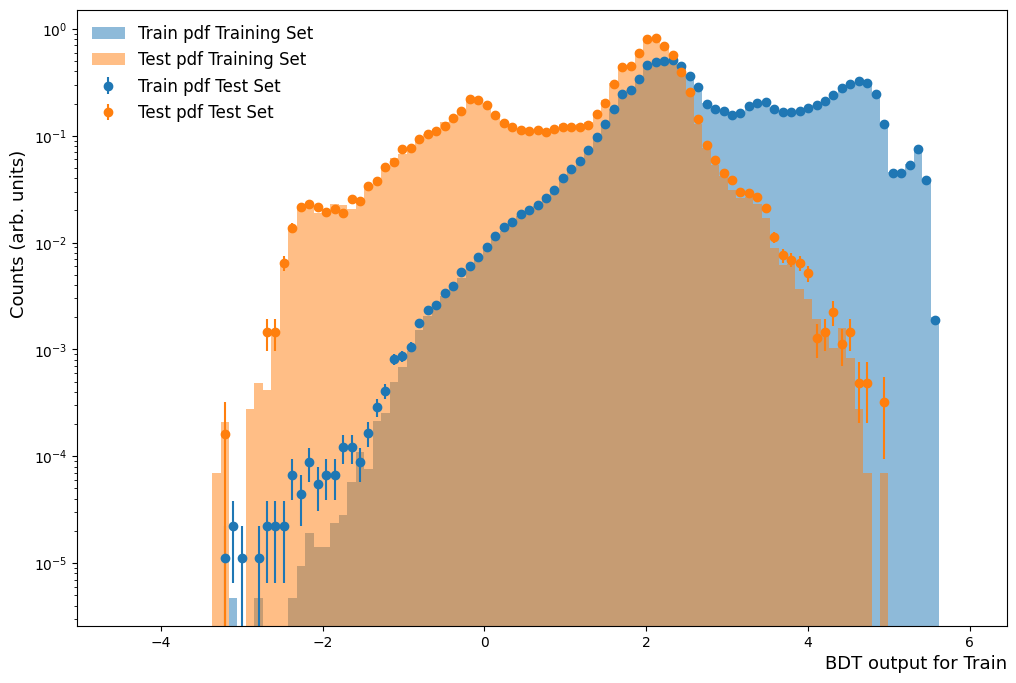

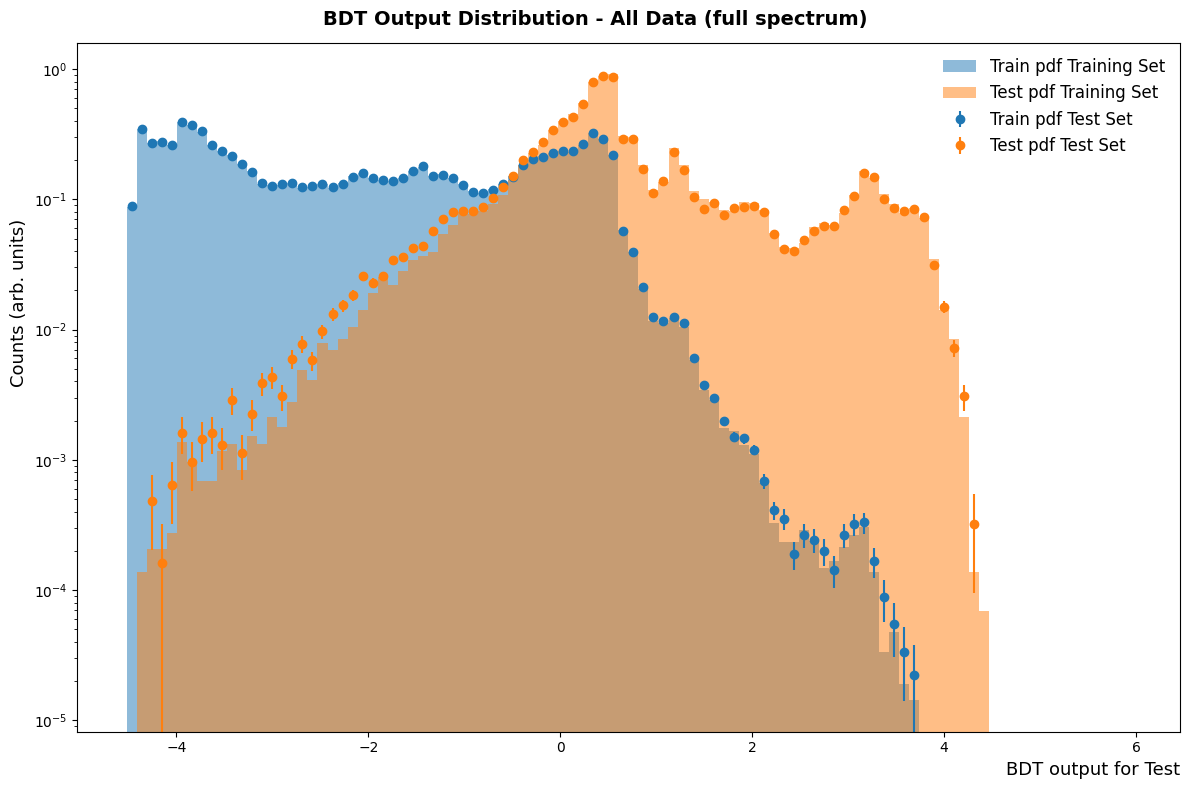

  BDT output plot created

  Generating ROC curves comparison...


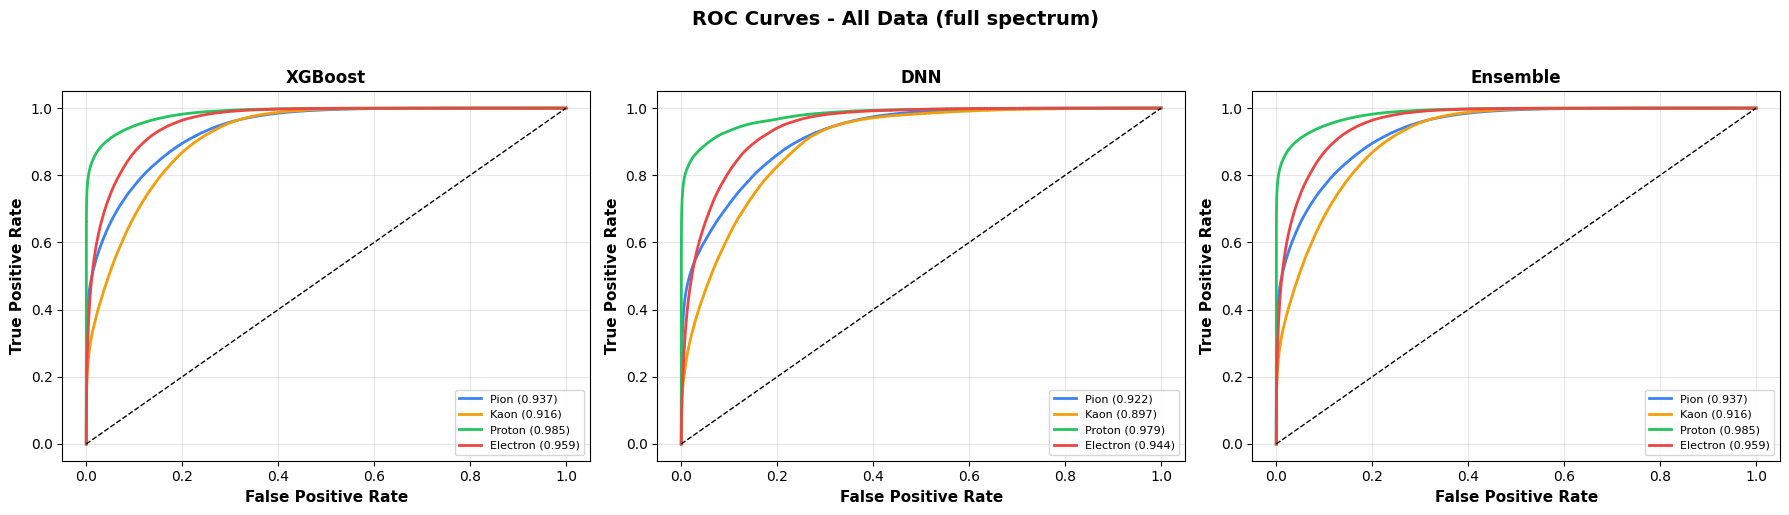

  ROC curves created

  Generating confusion matrices...


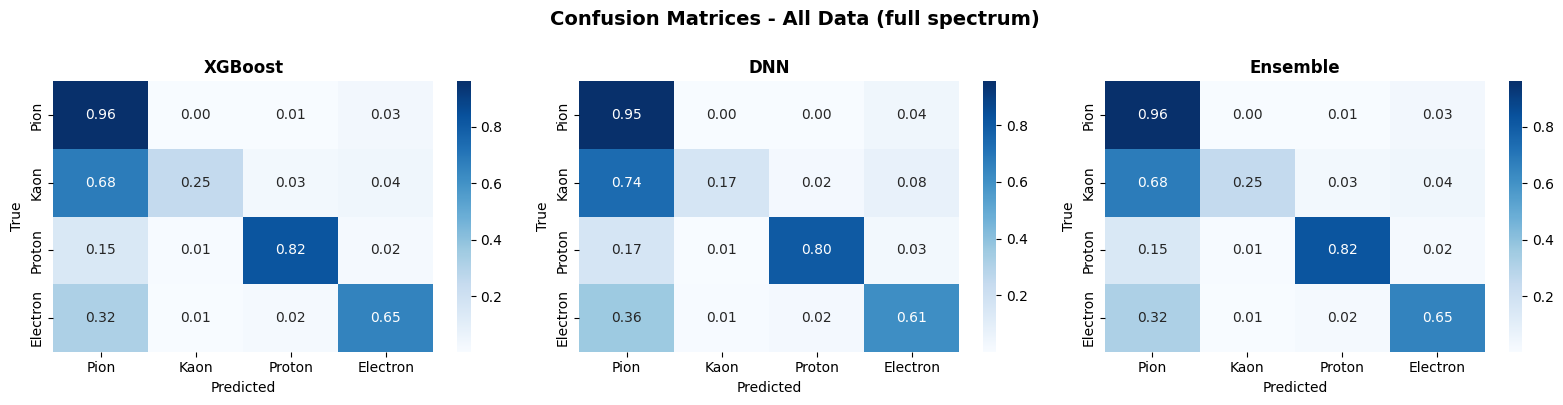

  Confusion matrices created

  Generating feature importance plot...


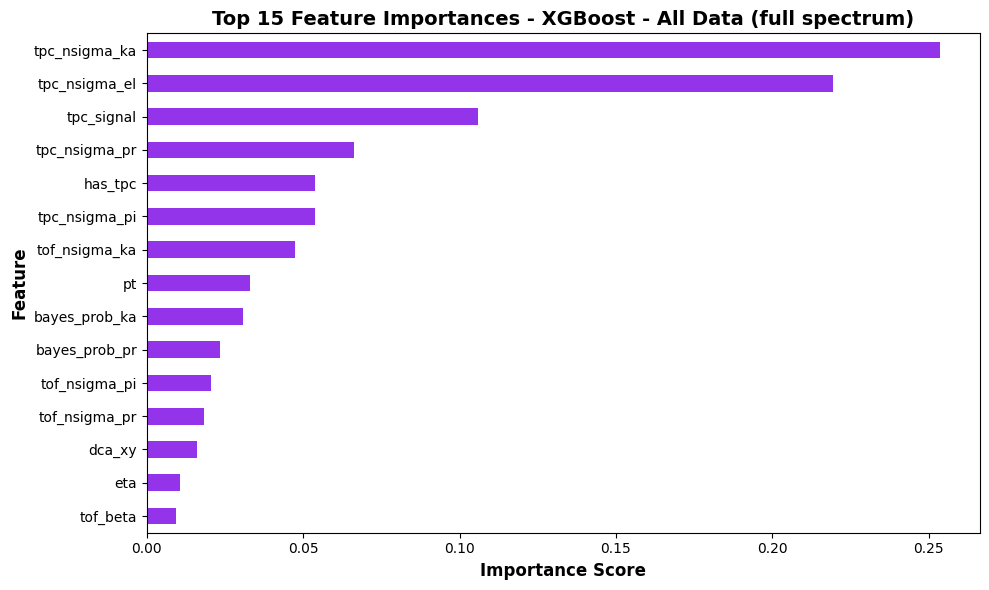

  Feature importance plot created



Visualisations: 0.1-1 GeV/c

  Generating BDT output distributions...


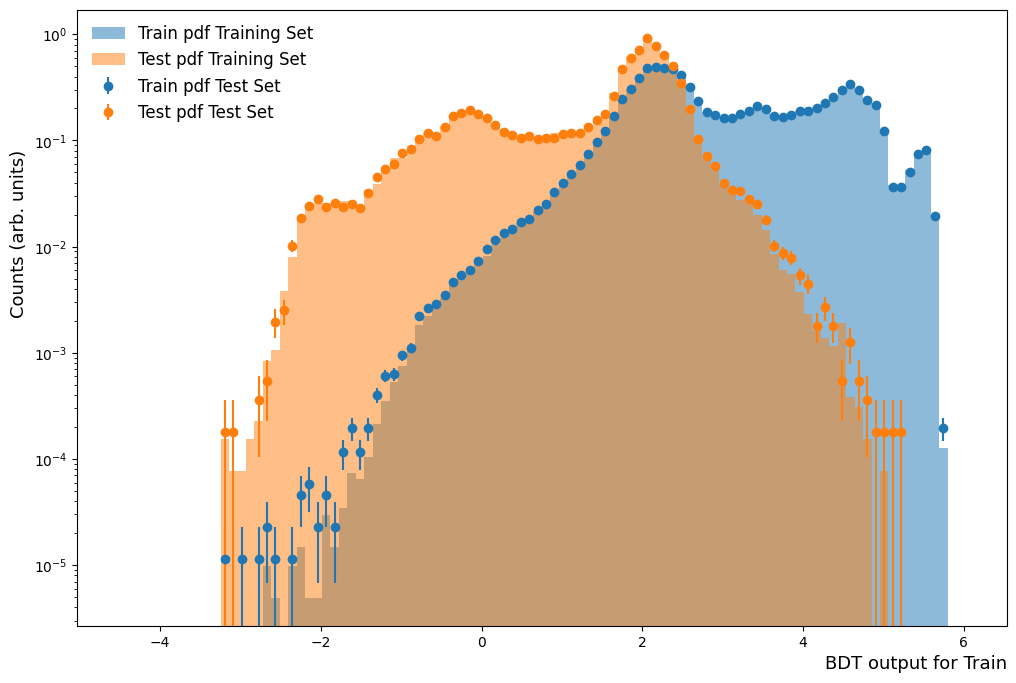

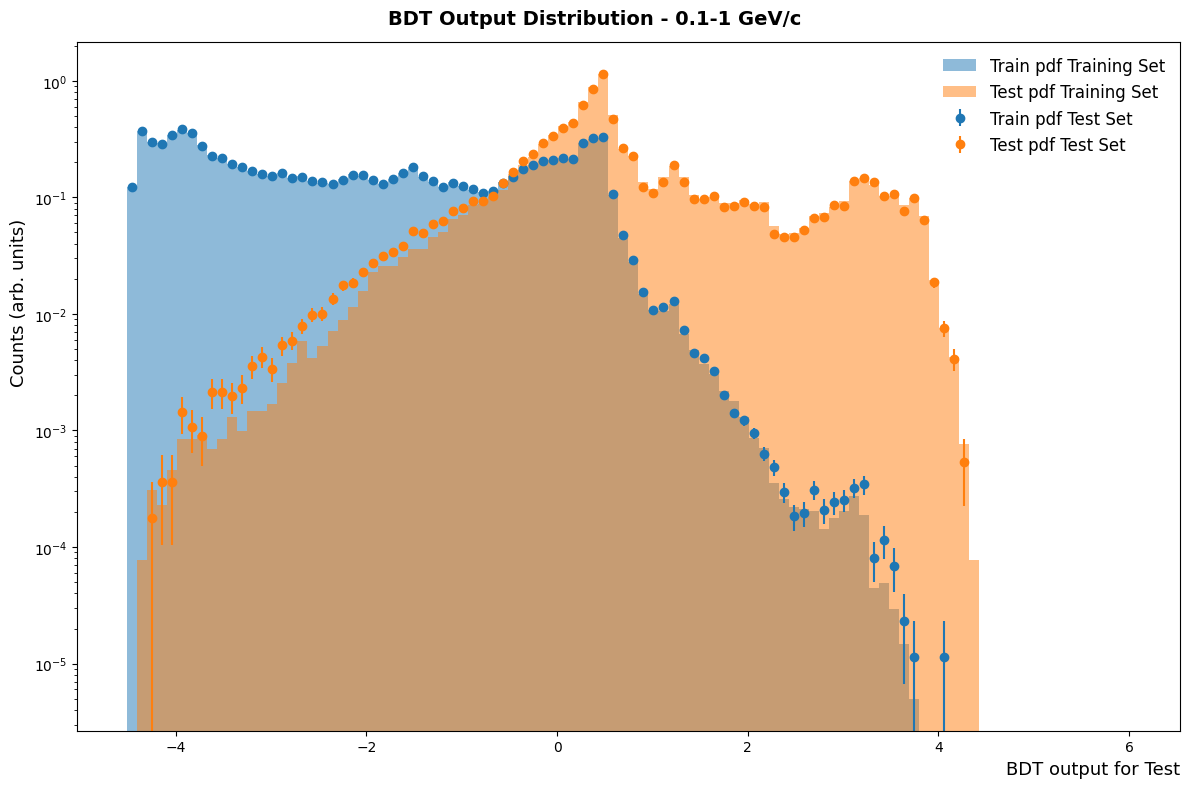

  BDT output plot created

  Generating ROC curves comparison...


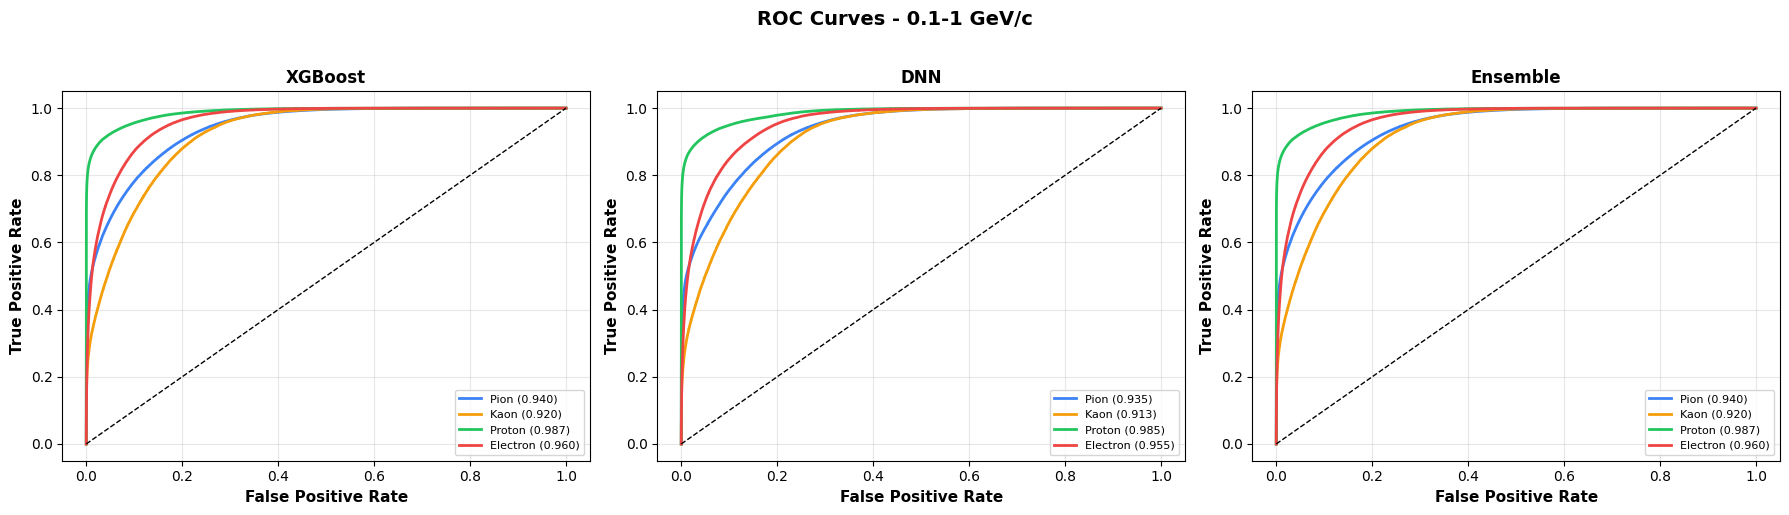

  ROC curves created

  Generating confusion matrices...


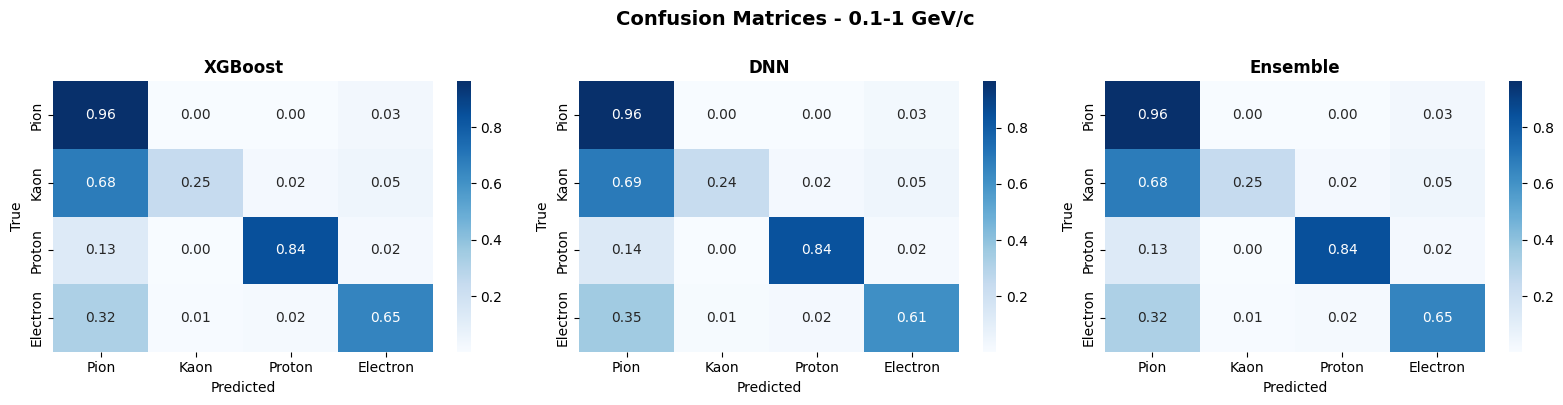

  Confusion matrices created

  Generating feature importance plot...


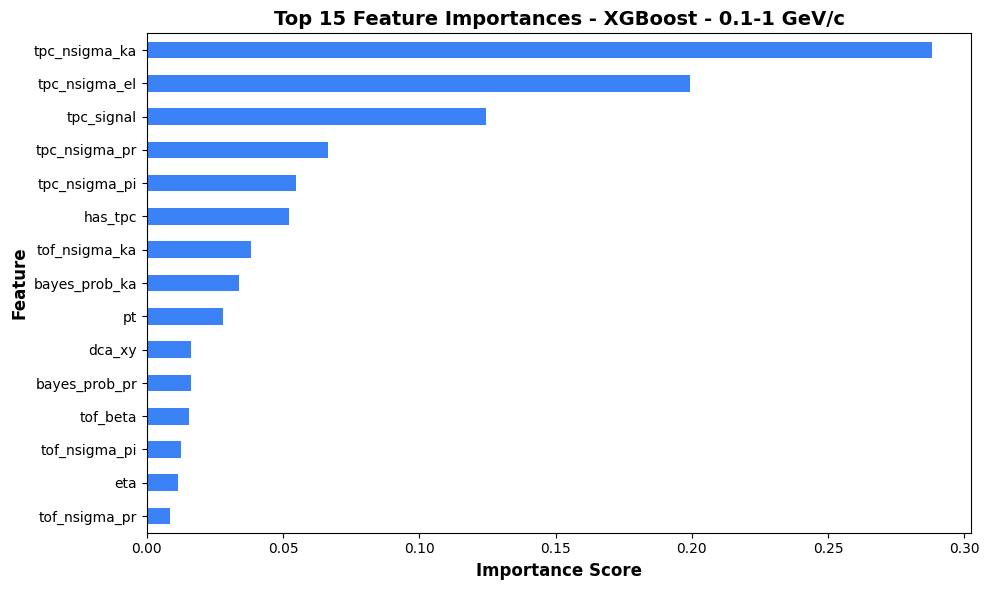

  Feature importance plot created



Visualisations: 1-3 GeV/c

  Generating BDT output distributions...


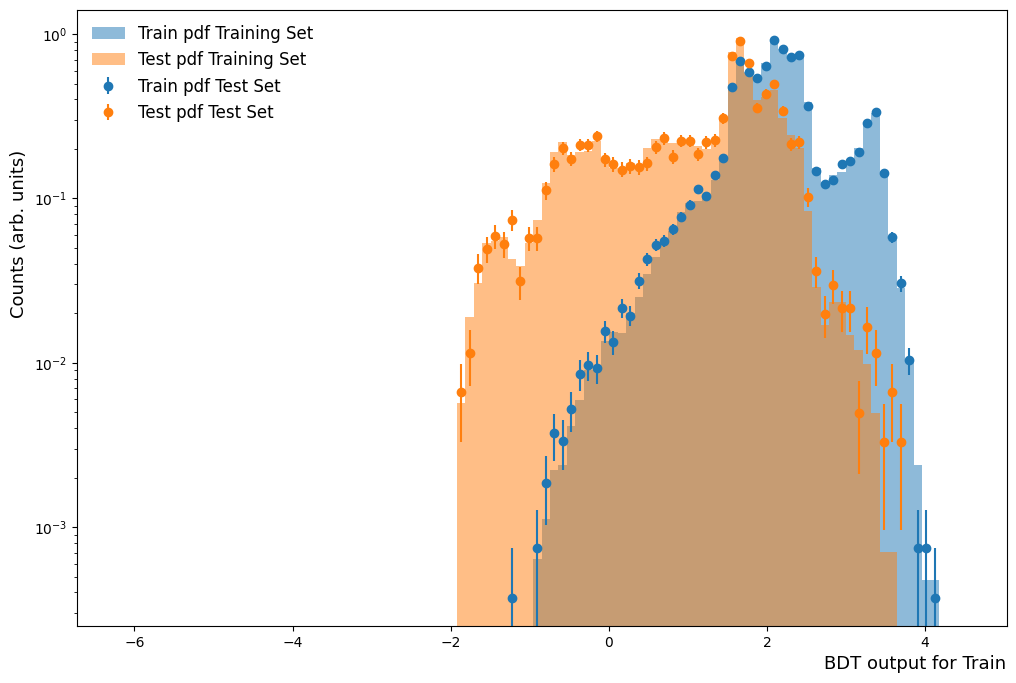

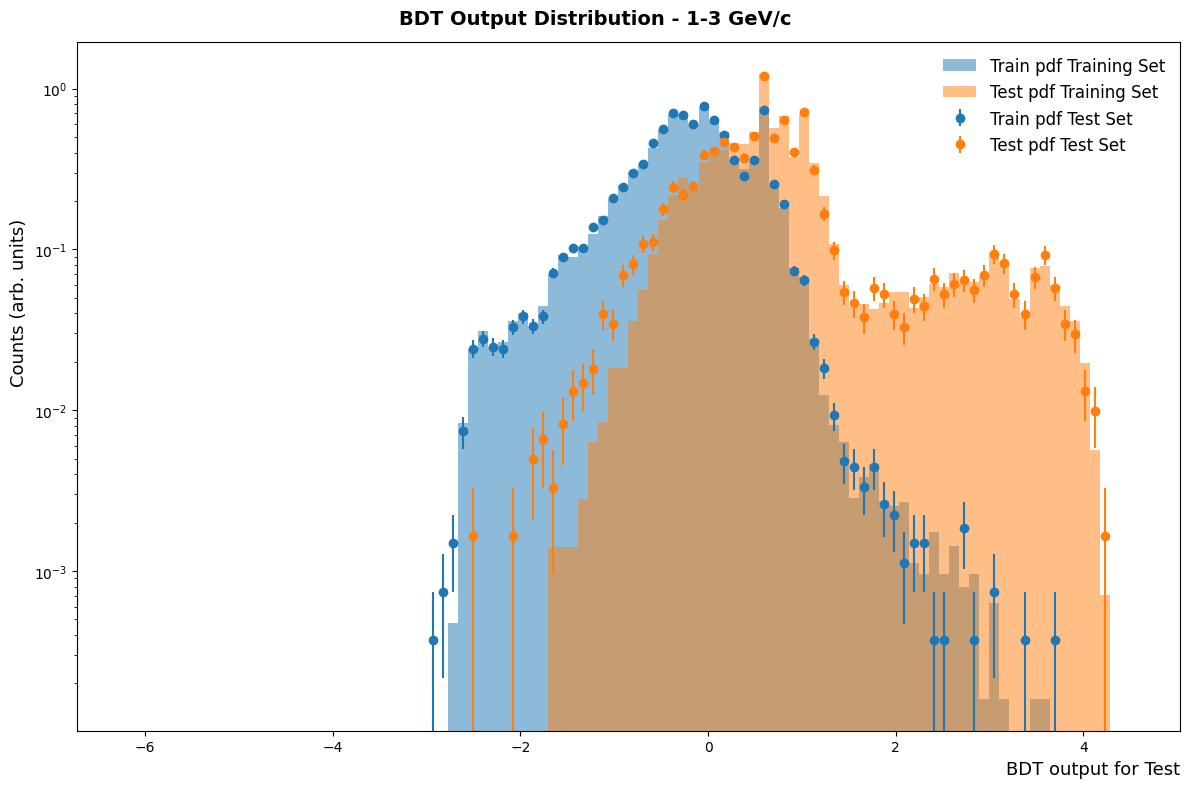

  BDT output plot created

  Generating ROC curves comparison...


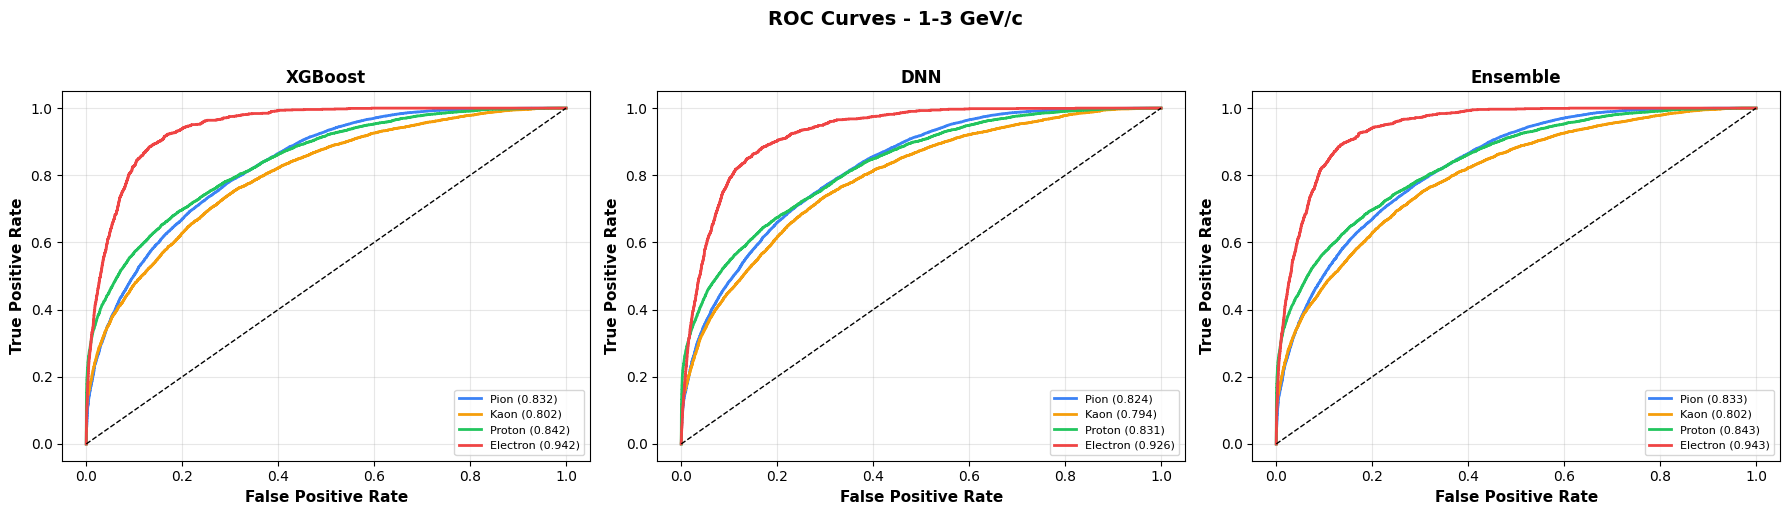

  ROC curves created

  Generating confusion matrices...


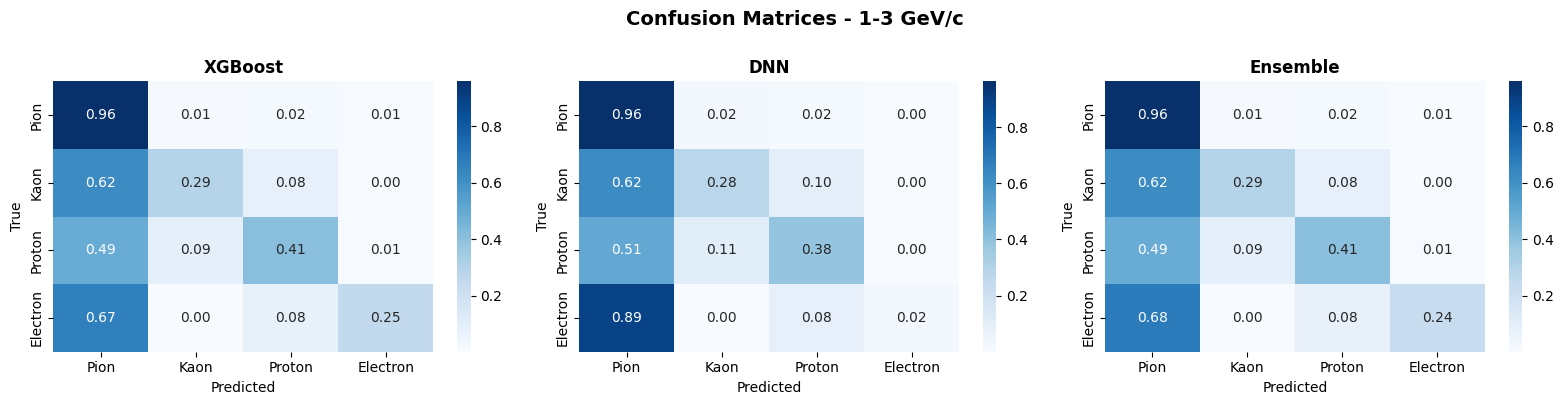

  Confusion matrices created

  Generating feature importance plot...


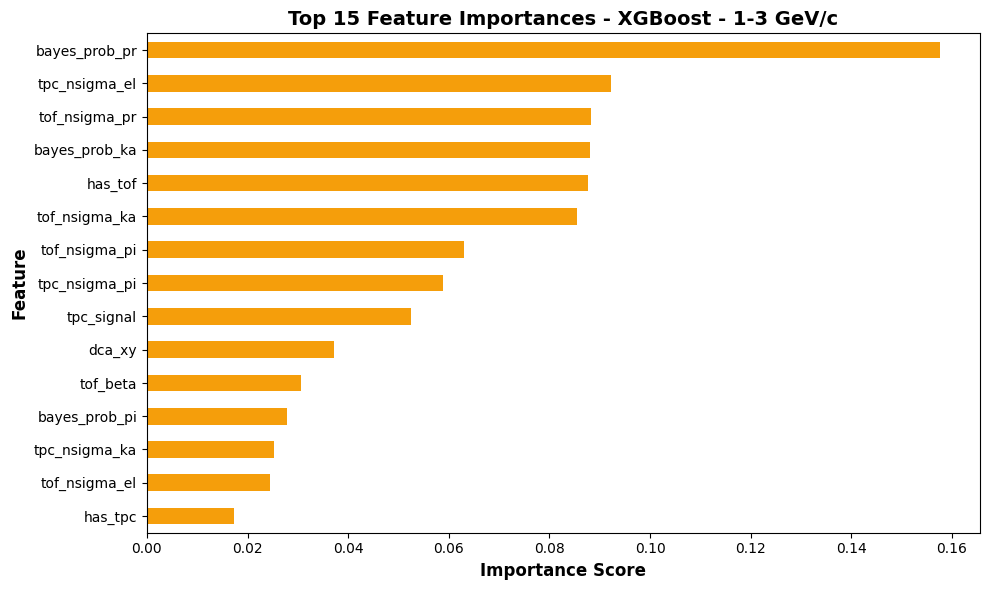

  Feature importance plot created



Visualisations: 3+ GeV/c

  Generating BDT output distributions...


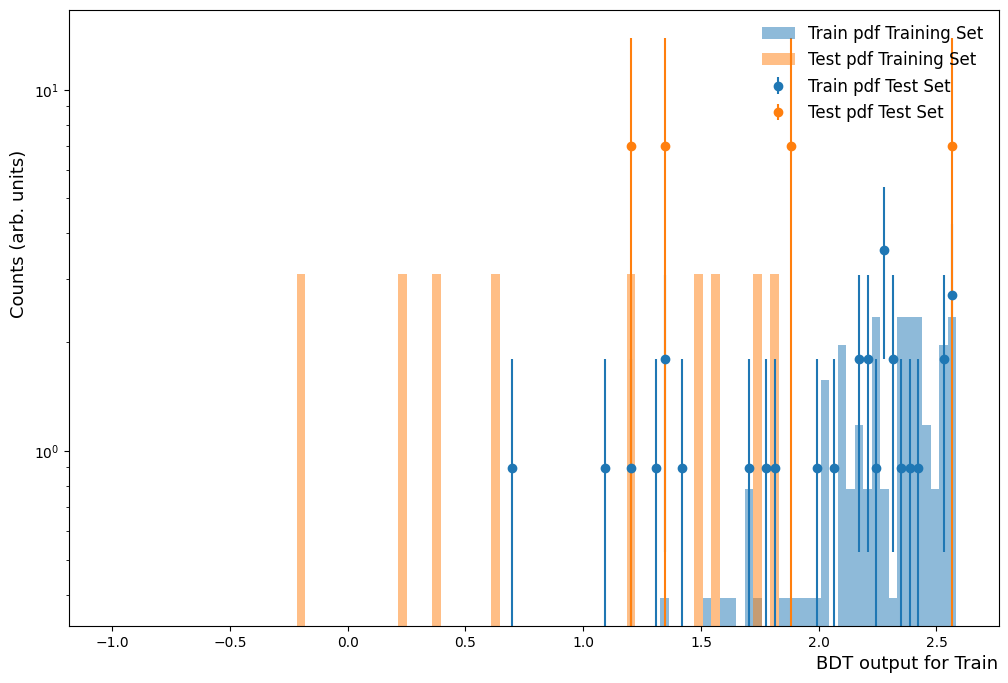

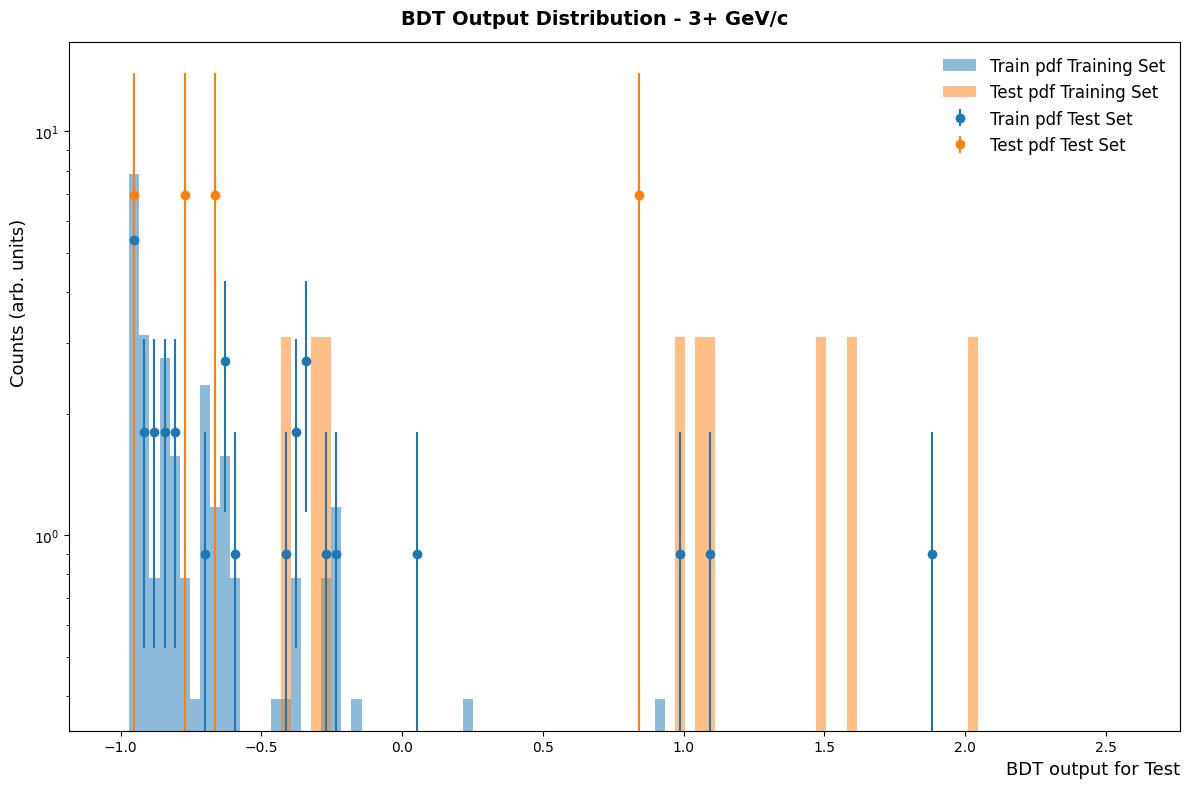

  BDT output plot created

  Generating ROC curves comparison...


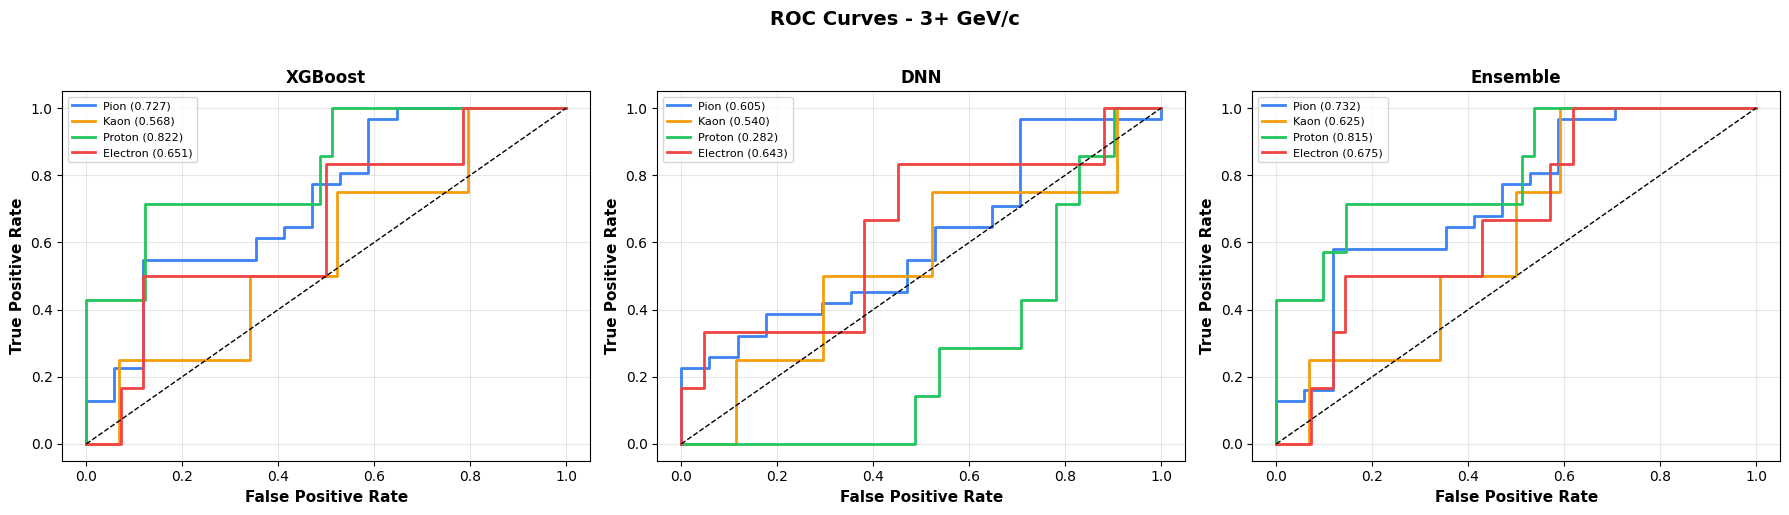

  ROC curves created

  Generating confusion matrices...


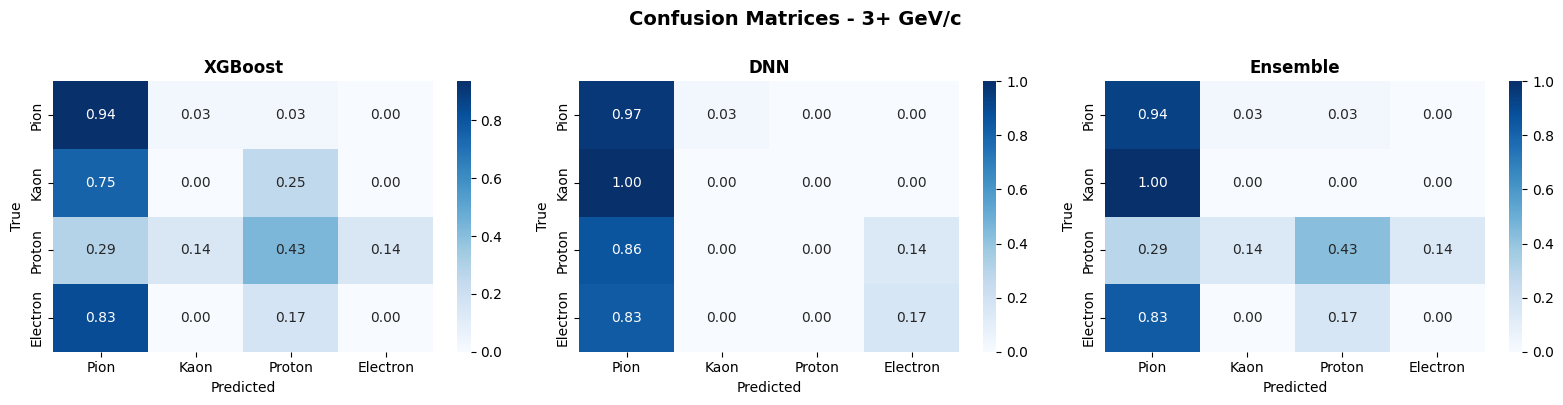

  Confusion matrices created

  Generating feature importance plot...


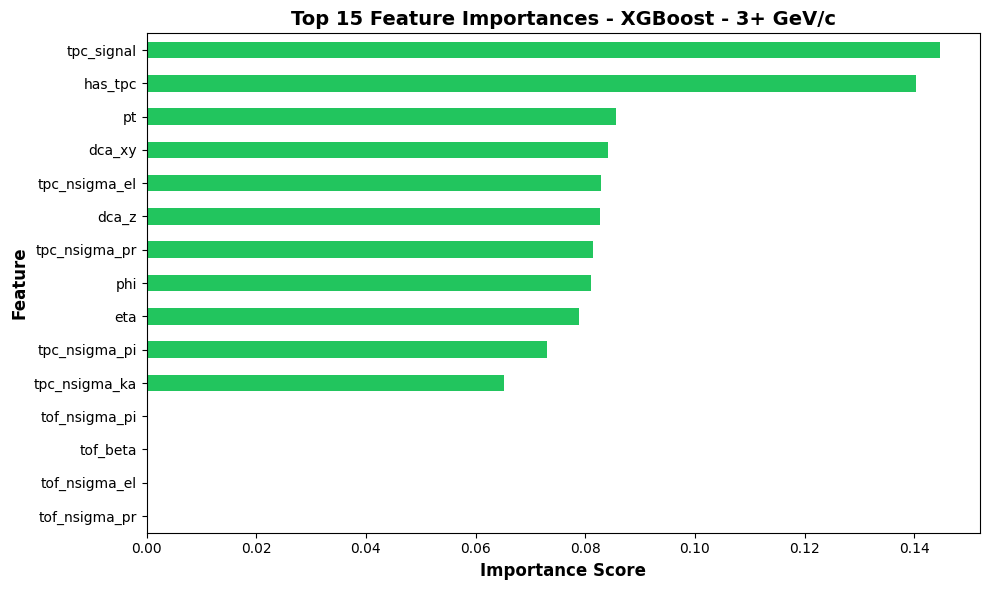

  Feature importance plot created


All visualisations complete


In [ ]:
print("\n" + "="*80)
print("SECTION 9: MODEL VISUALISATIONS")
print("="*80)

# Define colours for particles (one per particle type)
particle_colours = ['#3B82F6', '#F59E0B', '#22C55E', '#EF4444', '#8B5CF6']

for range_key in ['full', 'low', 'mid', 'high']:
    if range_key not in trained_xgb_models:
        continue

    range_name = momentum_datasets[range_key]['config']['name']
    print(f"\n{'='*70}")
    print(f"Visualisations: {range_name}")
    print(f"{'='*70}")

    y_test = momentum_datasets[range_key]['y_test'].values
    xgb_pred = trained_xgb_models[range_key]['y_pred_proba']
    dnn_pred = trained_dnn_models[range_key]['y_pred_proba']
    tabnet_pred = trained_tabnet_models[range_key]['y_pred_proba']
    ensemble_2way_pred = ensemble_models[range_key]['ensemble_pred']
    ensemble_3way_pred = ensemble_3way_models[range_key]['ensemble_pred']

    # BDT OUTPUT DISTRIBUTIONS (XGBoost only)
    print("\n  Generating BDT output distributions...")
    try:
        plt.rcParams['figure.figsize'] = (12, 8)
        X_train_plot = momentum_datasets[range_key]['X_train'].reset_index(drop=True)
        y_train_plot = momentum_datasets[range_key]['y_train'].reset_index(drop=True)
        X_test_plot = momentum_datasets[range_key]['X_test'].reset_index(drop=True)
        y_test_plot = momentum_datasets[range_key]['y_test'].reset_index(drop=True)

        plot_utils.plot_output_train_test(
            trained_xgb_models[range_key]['model_handler'],
            [X_train_plot, y_train_plot, X_test_plot, y_test_plot],
            bins=100, density=True, logscale=True, labels=['Train', 'Test']
        )
        plt.suptitle(f'BDT Output Distribution - {range_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("  BDT output plot created")
    except Exception as e:
        print(f"  Could not create BDT output plot: {e}")

    # 2. ROC CURVES COMPARISON (2-way Ensemble)
    print("\n  Generating ROC curves comparison (2-way ensemble)...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (pred, title) in enumerate([
        (xgb_pred, 'XGBoost'),
        (dnn_pred, 'DNN'),
        (ensemble_2way_pred, 'Ensemble 2-way')
    ]):
        ax = axes[idx]
        for particle_idx in range(len(PARTICLE_NAMES)):
            if particle_idx < len(particle_colours):
                colour = particle_colours[particle_idx]
            else:
                colour = '#999999'

            y_bin = (y_test == particle_idx).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, pred[:, particle_idx])
            from sklearn.metrics import auc as sklearn_auc
            roc_auc = sklearn_auc(fpr, tpr)
            ax.plot(fpr, tpr, color=colour, lw=2, label=f"{PARTICLE_NAMES[particle_idx]} ({roc_auc:.3f})")

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax.set_title(f'{title}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    plt.suptitle(f'ROC Curves (2-way) - {range_name}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    print("  ROC curves (2-way) created")

    # ROC CURVES COMPARISON (3-way Ensemble with TabNet)
    print("\n  Generating ROC curves comparison (3-way ensemble)...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (pred, title) in enumerate([
        (tabnet_pred, 'TabNet'),
        (ensemble_3way_pred, 'Ensemble 3-way'),
        (ensemble_2way_pred, 'Ensemble 2-way (ref)')
    ]):
        ax = axes[idx]
        for particle_idx in range(len(PARTICLE_NAMES)):
            if particle_idx < len(particle_colours):
                colour = particle_colours[particle_idx]
            else:
                colour = '#999999'

            y_bin = (y_test == particle_idx).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, pred[:, particle_idx])
            roc_auc = sklearn_auc(fpr, tpr)
            ax.plot(fpr, tpr, color=colour, lw=2, label=f"{PARTICLE_NAMES[particle_idx]} ({roc_auc:.3f})")

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax.set_title(f'{title}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    plt.suptitle(f'ROC Curves (3-way) - {range_name}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    print("  ROC curves (3-way) created")

    # CONFUSION MATRICES (5 models)
    print("\n  Generating confusion matrices...")
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    models_cm = [
        (xgb_pred, 'XGBoost'),
        (dnn_pred, 'DNN'),
        (tabnet_pred, 'TabNet'),
        (ensemble_2way_pred, 'Ensemble 2-way'),
        (ensemble_3way_pred, 'Ensemble 3-way')
    ]

    for idx, (pred, title) in enumerate(models_cm):
        ax = axes[idx]
        y_pred_labels = np.argmax(pred, axis=1)
        cm = confusion_matrix(y_test, y_pred_labels, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                    xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES, cbar_kws={'shrink': 0.8})
        ax.set_title(f'{title}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=10)
        ax.set_ylabel('True', fontsize=10)

    # Hide the last subplot
    axes[-1].axis('off')

    plt.suptitle(f'Confusion Matrices - {range_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("  Confusion matrices created")

    # FEATURE IMPORTANCE (XGBoost and TabNet)
    print("\n  Generating feature importance plots...")
    try:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # XGBoost feature importance
        fi_xgb = pd.Series(
            trained_xgb_models[range_key]['model_handler'].model.feature_importances_,
            index=available_features
        ).sort_values(ascending=False)

        fi_xgb.head(15).plot(kind='barh', ax=axes[0],
                            color=momentum_datasets[range_key]['config']['color'])
        axes[0].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
        axes[0].set_title(f'Top 15 Feature Importances - XGBoost', fontsize=13, fontweight='bold')
        axes[0].invert_yaxis()

        # TabNet feature importance
        fi_tabnet = trained_tabnet_models[range_key]['model'].feature_importances_
        fi_tabnet = pd.Series(fi_tabnet, index=available_features).sort_values(ascending=False)

        fi_tabnet.head(15).plot(kind='barh', ax=axes[1],
                               color=momentum_datasets[range_key]['config']['color'])
        axes[1].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Feature', fontsize=12, fontweight='bold')
        axes[1].set_title(f'Top 15 Feature Importances - TabNet', fontsize=13, fontweight='bold')
        axes[1].invert_yaxis()

        plt.tight_layout()
        plt.show()
        print("  Feature importance plots created")
    except Exception as e:
        print(f"  Could not create feature importance plots: {e}")

    # CUMULATIVE FEATURE IMPORTANCE (TabNet)
    print("\n  Generating cumulative feature importance...")
    try:
        fi_tabnet = trained_tabnet_models[range_key]['model'].feature_importances_
        fi_tabnet = pd.Series(fi_tabnet, index=available_features).sort_values(ascending=False)

        cumsum = fi_tabnet.values.cumsum() / fi_tabnet.values.sum()

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(cumsum)), cumsum, 'o-', linewidth=2.5, markersize=6,
                color=momentum_datasets[range_key]['config']['color'], label='Cumulative Importance')
        plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, linewidth=2, label='95% Threshold')
        plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='90% Threshold')
        plt.xlabel('Number of Features', fontsize=12, fontweight='bold')
        plt.ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
        plt.title(f'Cumulative Feature Importance - TabNet - {range_name}', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        print("  Cumulative feature importance plot created")
    except Exception as e:
        print(f"  Could not create cumulative feature importance plot: {e}")

    print("\n")

print("="*80)
print("All visualisations complete")
print("="*80)

## SECTION 10: Interactive Dashboard
### Compare Models Across Momentum Ranges

In [ ]:
print("\n" + "="*80)
print("SECTION 10: INTERACTIVE DASHBOARDS")
print("="*80)

# HELPER FUNCTIONS FOR INTERACTIVE PLOTS
def compute_pid_metrics(range_key, model_key):
    """Compute PID metrics (efficiency, purity) for a given model and momentum range."""
    if range_key not in momentum_datasets:
        return None

    y_test = momentum_datasets[range_key]['y_test'].values

    if model_key == 'XGBoost':
        y_pred_proba = trained_xgb_models[range_key]['y_pred_proba']
    elif model_key == 'DNN':
        y_pred_proba = trained_dnn_models[range_key]['y_pred_proba']
    elif model_key == 'TabNet':
        y_pred_proba = trained_tabnet_models[range_key]['y_pred_proba']
    elif model_key == 'Ensemble 2-way':
        y_pred_proba = ensemble_models[range_key]['ensemble_pred']
    else:  # Ensemble 3-way
        y_pred_proba = ensemble_3way_models[range_key]['ensemble_pred']

    y_pred_labels = np.argmax(y_pred_proba, axis=1)

    metrics_dict = {}
    for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
        y_bin = (y_test == particle_idx).astype(int)
        y_pred_bin = (y_pred_labels == particle_idx).astype(int)

        tp = np.sum((y_bin == 1) & (y_pred_bin == 1))
        fp = np.sum((y_bin == 0) & (y_pred_bin == 1))
        fn = np.sum((y_bin == 1) & (y_pred_bin == 0))
        tn = np.sum((y_bin == 0) & (y_pred_bin == 0))

        efficiency = tp / (tp + fn) if (tp + fn) > 0 else 0
        purity = tp / (tp + fp) if (tp + fp) > 0 else 0

        metrics_dict[particle_name] = {
            'efficiency': efficiency,
            'purity': purity,
            'tp': int(tp),
            'fp': int(fp)
        }

    return metrics_dict

def plot_comparison(particle, metric, model_key):
    """Plot metric comparison across momentum ranges as bar chart."""
    ranges = list(momentum_datasets.keys())
    values = []
    colors_list = []
    labels = []

    for r in ranges:
        metrics = compute_pid_metrics(r, model_key)
        if metrics and particle in metrics:
            values.append(metrics[particle][metric])
            colors_list.append(MOMENTUM_RANGES[r]['color'])
            labels.append(MOMENTUM_RANGES[r]['name'])

    if not values:
        print(f"No data available for {particle} - {metric}")
        return

    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, values, color=colors_list, alpha=0.8, edgecolor='black', linewidth=1.5)

    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{val:.3f}\n({val*100:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.ylabel(metric.capitalize(), fontsize=13, fontweight='bold')
    plt.xlabel('Momentum Range', fontsize=13, fontweight='bold')
    plt.title(f'{metric.capitalize()} for {particle} (Model: {model_key}) Across Momentum Ranges',
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=15, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    max_value = max(values)
    plt.ylim(0, max_value * 1.15)

    plt.tight_layout()
    plt.show()

def show_metrics_table(particle, model_key):
    """Display detailed metrics table for a particle across momentum ranges."""
    ranges = list(momentum_datasets.keys())
    data = []

    for r in ranges:
        metrics = compute_pid_metrics(r, model_key)
        if metrics and particle in metrics:
            m = metrics[particle]
            data.append({
                'Momentum Range': MOMENTUM_RANGES[r]['name'],
                'Efficiency': f"{m['efficiency']:.4f}",
                'Purity': f"{m['purity']:.4f}",
                'TP': m['tp'],
                'FP': m['fp']
            })

    df_t = pd.DataFrame(data)
    print(f"\n{'='*100}")
    print(f"Detailed Metrics: {particle.upper()} (Model: {model_key})")
    print(f"{'='*100}\n")
    print(df_t.to_string(index=False))
    print()

def plot_roc_comparison(particle, model_key):
    """Plot ROC curves for same particle across all momentum ranges."""
    particle_idx = PARTICLE_NAMES.index(particle)

    plt.figure(figsize=(10, 8))

    for range_key in momentum_datasets.keys():
        if model_key == 'XGBoost':
            if range_key not in trained_xgb_models:
                continue
            y_pred_proba = trained_xgb_models[range_key]['y_pred_proba']
        elif model_key == 'DNN':
            if range_key not in trained_dnn_models:
                continue
            y_pred_proba = trained_dnn_models[range_key]['y_pred_proba']
        elif model_key == 'TabNet':
            if range_key not in trained_tabnet_models:
                continue
            y_pred_proba = trained_tabnet_models[range_key]['y_pred_proba']
        elif model_key == 'Ensemble 2-way':
            if range_key not in ensemble_models:
                continue
            y_pred_proba = ensemble_models[range_key]['ensemble_pred']
        else:  # Ensemble 3-way
            if range_key not in ensemble_3way_models:
                continue
            y_pred_proba = ensemble_3way_models[range_key]['ensemble_pred']

        y_test = momentum_datasets[range_key]['y_test'].values
        y_bin = (y_test == particle_idx).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_pred_proba[:, particle_idx])
        from sklearn.metrics import auc as sklearn_auc
        roc_auc = sklearn_auc(fpr, tpr)

        plt.plot(fpr, tpr, color=MOMENTUM_RANGES[range_key]['color'], lw=2.5,
                label=f"{MOMENTUM_RANGES[range_key]['name']} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    plt.title(f'ROC Curves for {particle} (Model: {model_key}) Across Momentum Ranges',
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# INTERACTIVE DASHBOARD 1: PID PERFORMANCE ANALYSIS
print("\nDashboard 1: PID Performance Analysis")
print("Use the controls below to explore performance across models and momentum ranges:\n")

particle_dd = widgets.Dropdown(
    options=PARTICLE_NAMES,
    value='Pion',
    description='Select Particle:',
    style={'description_width': '150px'}
)

metric_dd = widgets.Dropdown(
    options=['efficiency', 'purity'],
    value='efficiency',
    description='Select Metric:',
    style={'description_width': '150px'}
)

model_dd = widgets.Dropdown(
    options=['XGBoost', 'DNN', 'TabNet', 'Ensemble 2-way', 'Ensemble 3-way'],
    value='XGBoost',
    description='Select Model:',
    style={'description_width': '150px'}
)

viz_type = widgets.RadioButtons(
    options=['Bar Chart', 'Metrics Table', 'ROC Curves'],
    value='Bar Chart',
    description='Visualisation Type:',
    style={'description_width': '150px'}
)

output = widgets.Output()

def update_interactive(change=None):
    """Update visualisation when controls change."""
    with output:
        clear_output(wait=True)

        particle = particle_dd.value
        metric = metric_dd.value
        model = model_dd.value
        viz = viz_type.value

        if viz == 'Bar Chart':
            plot_comparison(particle, metric, model)
        elif viz == 'Metrics Table':
            show_metrics_table(particle, model)
        else:  # ROC Curves
            plot_roc_comparison(particle, model)

particle_dd.observe(update_interactive, names='value')
metric_dd.observe(update_interactive, names='value')
model_dd.observe(update_interactive, names='value')
viz_type.observe(update_interactive, names='value')

title = widgets.HTML("<h3>PID Performance Comparison Across Momentum Ranges and Models</h3>")
controls = widgets.VBox([particle_dd, metric_dd, model_dd, viz_type])
ui = widgets.VBox([title, controls, output])

with output:
    plot_comparison('Pion', 'efficiency', 'XGBoost')

display(ui)
print("Dashboard 1 ready")

# INTERACTIVE DASHBOARD 2: MODEL COMPARISON BY RANGE
print("\n\nDashboard 2: Model Comparison by Momentum Range")

def compare_models(range_key):
    if range_key not in trained_xgb_models:
        return

    range_name = momentum_datasets[range_key]['config']['name']

    xgb_acc = trained_xgb_models[range_key]['test_acc']
    dnn_acc = trained_dnn_models[range_key]['test_acc']
    tabnet_acc = trained_tabnet_models[range_key]['test_acc']
    ens_2way_acc = ensemble_models[range_key]['ensemble_acc']
    ens_3way_acc = ensemble_3way_models[range_key]['ensemble_acc']

    models = ['XGBoost', 'DNN', 'TabNet', 'Ensemble\n(2-way)', 'Ensemble\n(3-way)']
    accuracies = [xgb_acc, dnn_acc, tabnet_acc, ens_2way_acc, ens_3way_acc]
    colors = ['#3B82F6', '#F59E0B', '#EC4899', '#22C55E', '#8B5CF6']

    plt.figure(figsize=(12, 6))
    bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.ylabel('Test Accuracy', fontsize=13, fontweight='bold')
    plt.title(f'Complete Model Comparison - {range_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylim(0, max(accuracies) * 1.15)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

range_dd = widgets.Dropdown(
    options=list(momentum_datasets.keys()),
    value='full',
    description='Momentum Range:',
    style={'description_width': '150px'}
)

output_models = widgets.Output()

def update_dashboard(change=None):
    with output_models:
        clear_output(wait=True)
        compare_models(range_dd.value)

range_dd.observe(update_dashboard, names='value')

ui_models = widgets.VBox([
    widgets.HTML("<h3>Model Comparison by Momentum Range</h3>"),
    range_dd,
    output_models
])

with output_models:
    compare_models('full')

display(ui_models)
print("Dashboard 2 ready")

print("\n" + "="*80)
print("All interactive dashboards ready")
print("="*80)


SECTION 10: INTERACTIVE DASHBOARD

Use the controls below to explore PID performance:



Interactive dashboard ready


Model comparison dashboard ready

All interactive dashboards ready


## SECTION 11: Final Summary
### Analysis Complete - Results Overview

In [ ]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\nModels trained for {len(momentum_datasets)} momentum ranges:")
print(f"  XGBoost models:  {len(trained_xgb_models)}")
print(f"  DNN models:      {len(trained_dnn_models)}")
print(f"  TabNet models:   {len(trained_tabnet_models)}")
print(f"  2-way Ensemble:  {len(ensemble_models)}")
print(f"  3-way Ensemble:  {len(ensemble_3way_models)}")

print(f"\nModels saved to:")
print(f"  XGBoost:   {MODEL_SAVE_DIR}")
print(f"  DNN:       {DNN_SAVE_DIR}")
print(f"  TabNet:    {DNN_SAVE_DIR}")
print(f"  Optuna:    {OPTUNA_SAVE_DIR}")

print(f"\nBest Results Summary:")
print("="*80)

for range_key in momentum_datasets.keys():
    if range_key in ensemble_3way_models:
        range_name = momentum_datasets[range_key]['config']['name']

        xgb_acc = trained_xgb_models[range_key]['test_acc']
        dnn_acc = trained_dnn_models[range_key]['test_acc']
        tabnet_acc = trained_tabnet_models[range_key]['test_acc']
        ens_2way_acc = ensemble_models[range_key]['ensemble_acc']
        ens_3way_acc = ensemble_3way_models[range_key]['ensemble_acc']

        best_single = max(xgb_acc, dnn_acc, tabnet_acc)

        print(f"\n{range_name}:")
        print(f"  Single Models:")
        print(f"    XGBoost: {xgb_acc:.4f}")
        print(f"    DNN:     {dnn_acc:.4f}")
        print(f"    TabNet:  {tabnet_acc:.4f}")
        print(f"  Ensembles:")
        print(f"    2-way:   {ens_2way_acc:.4f} (Weights: XGB={ensemble_models[range_key]['xgb_weight']:.2f}, DNN={ensemble_models[range_key]['dnn_weight']:.2f})")
        print(f"    3-way:   {ens_3way_acc:.4f} (Weights: XGB={ensemble_3way_models[range_key]['xgb_weight']:.2f}, DNN={ensemble_3way_models[range_key]['dnn_weight']:.2f}, TabNet={ensemble_3way_models[range_key]['tabnet_weight']:.2f})")

        improvement_3way = ens_3way_acc - best_single
        print(f"  Improvement (3-way vs best single): +{improvement_3way*100:.2f}%")

print("\n" + "="*80)
print("Notebook execution complete")
print("="*80 + "\n")


ANALYSIS COMPLETE

✓ Models trained for 4 momentum ranges:
  • XGBoost models: 4
  • DNN models: 4
  • Ensemble models: 4

✓ Models saved to:
  • XGBoost: /content/drive/MyDrive/PID_Models/XGBoost/
  • DNN: /content/drive/MyDrive/PID_Models/DNN/
  • Optuna: /content/drive/MyDrive/PID_Models/Optuna_Studies/

✓ Best Results Summary:

  All Data (full spectrum):
    Ensemble Accuracy: 0.8675
    Weights: XGBoost=1.00, DNN=0.00

  0.1-1 GeV/c:
    Ensemble Accuracy: 0.8741
    Weights: XGBoost=1.00, DNN=0.00

  1-3 GeV/c:
    Ensemble Accuracy: 0.7470
    Weights: XGBoost=0.90, DNN=0.10

  3+ GeV/c:
    Ensemble Accuracy: 0.6667
    Weights: XGBoost=0.80, DNN=0.20
